In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import zipfile
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [3]:
# Load the CSV data
data = pd.read_csv('/kaggle/input/biomaterial-attachement/BacteriaA.csv')

In [4]:
# List all image IDs from the unzipped images
image_ids = [int(file.split('.')[0]) for file in os.listdir("/kaggle/input/biomaterial-attachement/ProcessedImages")]

# Convert image IDs to a DataFrame
image_ids_df = pd.DataFrame(image_ids, columns=['FeatID'])

# Merge with the ground truth data
merged_data = pd.merge(image_ids_df, data, how='inner', on='FeatID')

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transforms.Compose([transforms.Resize((200, 200)), transform])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, f"{img_id}.png")
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        ground_truth = self.dataframe.iloc[idx, 1]
        ground_truth = torch.tensor(ground_truth).float()

        return image, ground_truth

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(200*200*3+1, 400)
        self.bn1 = nn.BatchNorm1d(400)  # Batch normalization layer
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20+1, 400)
        self.bn2 = nn.BatchNorm1d(400)  # Batch normalization layer
        self.fc4 = nn.Linear(400, 200*200*3)

    def encode(self, x):
        h1 = F.relu(self.bn1(self.fc1(x)))  # Apply batch normalization after fc1
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.bn2(self.fc3(z)))  # Apply batch normalization after fc3
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, ground_truth):
        mu, logvar = self.encode(torch.cat((x, ground_truth), dim=-1))
        z = self.reparameterize(mu, logvar)
        return self.decode(torch.cat((z, ground_truth), dim=-1)), mu, logvar

In [7]:
# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [8]:
# Create the dataset
dataset = CustomDataset(merged_data, "/kaggle/input/biomaterial-attachement/ProcessedImages", transform=transform)

In [9]:
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [10]:
device = torch.device("cuda:0")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# Create the VAE
vae = VAE().to(device)

In [12]:
# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [13]:
def loss_function(recon_x, x, mu, logvar):
    print(recon_x.min(), recon_x.max())  # Add this line
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 200*200*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [14]:
import os
import sys
from contextlib import contextmanager

@contextmanager
def suppress_output():
    # Open a null stream to suppress output
    with open(os.devnull, 'w') as fnull:
        # Save the current stdout
        original_stdout = sys.stdout
        # Redirect stdout to the null stream
        sys.stdout = fnull
        yield
        # Restore stdout
        sys.stdout = original_stdout

In [15]:
def train(epoch):
    vae.train()
    train_loss = 0
    with suppress_output():  # Suppress tensor-related verbose output
        for batch_idx, (data, ground_truth) in enumerate(dataloader):
            data = data.view(data.size(0), -1).to(device)
            ground_truth = ground_truth.view(ground_truth.size(0), -1).to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data, ground_truth)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1)  # Apply gradient clipping
            train_loss += loss.item()
            optimizer.step()

    print('====> Epoch: {}'.format(epoch))

In [16]:
from torchvision.models import inception_v3
from scipy.linalg import sqrtm

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def get_activations(images, model, batch_size=32, device='cuda'):
    model = model.to(device)
    model.eval()
    activations = []
    n_batches = len(images) // batch_size
    for i in range(n_batches):
        inputs = images[i * batch_size : (i+1) * batch_size].to(device)
        with torch.no_grad():
            preds = model(inputs).detach().cpu().numpy()
        activations.append(preds)
    activations = np.concatenate(activations, axis=0)
    return activations

inception_model = inception_v3(pretrained=True, transform_input=False, init_weights=False)
inception_model.fc = nn.Identity()  # Modify model to return the 2048 feature before the final fully connected layer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoin

In [27]:
# Train the model
from tqdm import tqdm

fid_scores = []

num_epochs = 1000
for epoch in tqdm(range(1, num_epochs + 1), desc="Training"):
    train(epoch)
    with torch.no_grad():
        # Sample a batch of real images from the dataset
        real_images, ground_truth = next(iter(dataloader))  # Just taking one batch for simplicity
        real_images = real_images.view(real_images.size(0), -1).to(device)
        ground_truth = ground_truth.view(ground_truth.size(0), -1).to(device)
        
        # Generate a batch of images using the trained VAE
        noise = torch.randn(real_images.size(0), 20).to(device)
        # Assuming ground_truth is available and has the same batch size
        concatenated_noise = torch.cat((noise, ground_truth), dim=-1)
        generated_images = vae.decode(concatenated_noise)
        
        # Reshape the images to 4D
        real_images = real_images.view(-1, 3, 200, 200)
        generated_images = generated_images.view(-1, 3, 200, 200)
        
        # Get activations
        real_activations = get_activations(real_images, inception_model, device=device)
        generated_activations = get_activations(generated_images, inception_model, device=device)
        
        # Calculate FID score between real_images and generated_images
        fid_score = calculate_fid(real_activations, generated_activations)
        fid_scores.append(fid_score)
        
    print(f"Epoch {epoch}, FID Score: {fid_score}")

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

====> Epoch: 1


Training:   0%|          | 1/1000 [00:17<4:59:25, 17.98s/it]

Epoch 1, FID Score: 1647.5593442601755
====> Epoch: 2


Training:   0%|          | 2/1000 [00:35<4:49:43, 17.42s/it]

Epoch 2, FID Score: 1668.843939136682
====> Epoch: 3


Training:   0%|          | 3/1000 [00:51<4:42:04, 16.98s/it]

Epoch 3, FID Score: 1708.5783977086464
====> Epoch: 4


Training:   0%|          | 4/1000 [01:07<4:37:01, 16.69s/it]

Epoch 4, FID Score: 1736.5308718283807
====> Epoch: 5


Training:   0%|          | 5/1000 [01:23<4:33:33, 16.50s/it]

Epoch 5, FID Score: 1718.8911100091746
====> Epoch: 6


Training:   1%|          | 6/1000 [01:40<4:33:54, 16.53s/it]

Epoch 6, FID Score: 1598.8356890901603
====> Epoch: 7


Training:   1%|          | 7/1000 [01:56<4:31:14, 16.39s/it]

Epoch 7, FID Score: 1691.0430831985843
====> Epoch: 8


Training:   1%|          | 8/1000 [02:12<4:30:42, 16.37s/it]

Epoch 8, FID Score: 1709.634546146604
====> Epoch: 9


Training:   1%|          | 9/1000 [02:28<4:28:07, 16.23s/it]

Epoch 9, FID Score: 1776.3371935972007
====> Epoch: 10


Training:   1%|          | 10/1000 [02:45<4:30:45, 16.41s/it]

Epoch 10, FID Score: 1604.7265557193894
====> Epoch: 11


Training:   1%|          | 11/1000 [03:01<4:29:03, 16.32s/it]

Epoch 11, FID Score: 1778.4006642485508
====> Epoch: 12


Training:   1%|          | 12/1000 [03:18<4:29:20, 16.36s/it]

Epoch 12, FID Score: 1708.7186367545273
====> Epoch: 13


Training:   1%|▏         | 13/1000 [03:34<4:28:29, 16.32s/it]

Epoch 13, FID Score: 1714.438353997121
====> Epoch: 14


Training:   1%|▏         | 14/1000 [03:51<4:30:42, 16.47s/it]

Epoch 14, FID Score: 1645.8613043585808
====> Epoch: 15


Training:   2%|▏         | 15/1000 [04:07<4:28:13, 16.34s/it]

Epoch 15, FID Score: 1656.3620443018629
====> Epoch: 16


Training:   2%|▏         | 16/1000 [04:24<4:32:27, 16.61s/it]

Epoch 16, FID Score: 1708.6342735734347
====> Epoch: 17


Training:   2%|▏         | 17/1000 [04:41<4:36:05, 16.85s/it]

Epoch 17, FID Score: 1601.751973659047
====> Epoch: 18


Training:   2%|▏         | 18/1000 [04:59<4:37:33, 16.96s/it]

Epoch 18, FID Score: 1707.532594500699
====> Epoch: 19


Training:   2%|▏         | 19/1000 [05:15<4:36:39, 16.92s/it]

Epoch 19, FID Score: 1751.6807760609556
====> Epoch: 20


Training:   2%|▏         | 20/1000 [05:32<4:34:54, 16.83s/it]

Epoch 20, FID Score: 1736.782579275744
====> Epoch: 21


Training:   2%|▏         | 21/1000 [05:49<4:37:15, 16.99s/it]

Epoch 21, FID Score: 1698.711757436818
====> Epoch: 22


Training:   2%|▏         | 22/1000 [06:06<4:34:38, 16.85s/it]

Epoch 22, FID Score: 1771.0400912191378
====> Epoch: 23


Training:   2%|▏         | 23/1000 [06:23<4:34:14, 16.84s/it]

Epoch 23, FID Score: 1663.4997841524337
====> Epoch: 24


Training:   2%|▏         | 24/1000 [06:39<4:32:02, 16.72s/it]

Epoch 24, FID Score: 1720.6235846384639
====> Epoch: 25


Training:   2%|▎         | 25/1000 [06:56<4:33:12, 16.81s/it]

Epoch 25, FID Score: 1733.1666282232404
====> Epoch: 26


Training:   3%|▎         | 26/1000 [07:13<4:30:39, 16.67s/it]

Epoch 26, FID Score: 1635.6779469726848
====> Epoch: 27


Training:   3%|▎         | 27/1000 [07:29<4:30:43, 16.69s/it]

Epoch 27, FID Score: 1726.7052729169554
====> Epoch: 28


Training:   3%|▎         | 28/1000 [07:46<4:31:58, 16.79s/it]

Epoch 28, FID Score: 1641.0364061417079
====> Epoch: 29


Training:   3%|▎         | 29/1000 [08:03<4:32:47, 16.86s/it]

Epoch 29, FID Score: 1729.585494477391
====> Epoch: 30


Training:   3%|▎         | 30/1000 [08:20<4:32:02, 16.83s/it]

Epoch 30, FID Score: 1684.4515681186251
====> Epoch: 31


Training:   3%|▎         | 31/1000 [08:37<4:32:32, 16.88s/it]

Epoch 31, FID Score: 1660.5033433642598
====> Epoch: 32


Training:   3%|▎         | 32/1000 [08:54<4:30:14, 16.75s/it]

Epoch 32, FID Score: 1608.301396363216
====> Epoch: 33


Training:   3%|▎         | 33/1000 [09:10<4:29:43, 16.74s/it]

Epoch 33, FID Score: 1606.5188473240619
====> Epoch: 34


Training:   3%|▎         | 34/1000 [09:27<4:28:46, 16.69s/it]

Epoch 34, FID Score: 1662.7364753839456
====> Epoch: 35


Training:   4%|▎         | 35/1000 [09:44<4:30:42, 16.83s/it]

Epoch 35, FID Score: 1650.5300276126266
====> Epoch: 36


Training:   4%|▎         | 36/1000 [10:00<4:26:43, 16.60s/it]

Epoch 36, FID Score: 1666.1607671007623
====> Epoch: 37


Training:   4%|▎         | 37/1000 [10:17<4:27:34, 16.67s/it]

Epoch 37, FID Score: 1676.0556968110309
====> Epoch: 38


Training:   4%|▍         | 38/1000 [10:34<4:27:10, 16.66s/it]

Epoch 38, FID Score: 1672.5215801974466
====> Epoch: 39


Training:   4%|▍         | 39/1000 [10:50<4:27:16, 16.69s/it]

Epoch 39, FID Score: 1726.6613617469175
====> Epoch: 40


Training:   4%|▍         | 40/1000 [11:08<4:29:38, 16.85s/it]

Epoch 40, FID Score: 1640.5048012337836
====> Epoch: 41


Training:   4%|▍         | 41/1000 [11:24<4:25:44, 16.63s/it]

Epoch 41, FID Score: 1834.4801658591127
====> Epoch: 42


Training:   4%|▍         | 42/1000 [11:41<4:27:33, 16.76s/it]

Epoch 42, FID Score: 1706.6888834278873
====> Epoch: 43


Training:   4%|▍         | 43/1000 [11:57<4:23:54, 16.55s/it]

Epoch 43, FID Score: 1762.8174637648249
====> Epoch: 44


Training:   4%|▍         | 44/1000 [12:14<4:25:20, 16.65s/it]

Epoch 44, FID Score: 1647.0028666481398
====> Epoch: 45


Training:   4%|▍         | 45/1000 [12:30<4:23:03, 16.53s/it]

Epoch 45, FID Score: 1673.7870772528327
====> Epoch: 46


Training:   5%|▍         | 46/1000 [12:47<4:27:06, 16.80s/it]

Epoch 46, FID Score: 1571.3351027529252
====> Epoch: 47


Training:   5%|▍         | 47/1000 [13:04<4:26:51, 16.80s/it]

Epoch 47, FID Score: 1647.725298603682
====> Epoch: 48


Training:   5%|▍         | 48/1000 [13:22<4:31:36, 17.12s/it]

Epoch 48, FID Score: 1735.9405440503938
====> Epoch: 49


Training:   5%|▍         | 49/1000 [13:39<4:32:38, 17.20s/it]

Epoch 49, FID Score: 1603.211664476751
====> Epoch: 50


Training:   5%|▌         | 50/1000 [13:58<4:37:10, 17.51s/it]

Epoch 50, FID Score: 1653.4961798362165
====> Epoch: 51


Training:   5%|▌         | 51/1000 [14:15<4:36:41, 17.49s/it]

Epoch 51, FID Score: 1597.8555606056407
====> Epoch: 52


Training:   5%|▌         | 52/1000 [14:33<4:37:39, 17.57s/it]

Epoch 52, FID Score: 1649.4740025972887
====> Epoch: 53


Training:   5%|▌         | 53/1000 [14:53<4:49:26, 18.34s/it]

Epoch 53, FID Score: 1723.4677792708553
====> Epoch: 54


Training:   5%|▌         | 54/1000 [15:11<4:48:08, 18.27s/it]

Epoch 54, FID Score: 1596.4035307132285
====> Epoch: 55


Training:   6%|▌         | 55/1000 [15:30<4:49:51, 18.40s/it]

Epoch 55, FID Score: 1613.5459335121684
====> Epoch: 56


Training:   6%|▌         | 56/1000 [15:49<4:51:15, 18.51s/it]

Epoch 56, FID Score: 1577.0489537625194
====> Epoch: 57


Training:   6%|▌         | 57/1000 [16:08<4:53:42, 18.69s/it]

Epoch 57, FID Score: 1666.5919990148252
====> Epoch: 58


Training:   6%|▌         | 58/1000 [16:26<4:51:31, 18.57s/it]

Epoch 58, FID Score: 1618.9580233982026
====> Epoch: 59


Training:   6%|▌         | 59/1000 [16:45<4:52:13, 18.63s/it]

Epoch 59, FID Score: 1656.6723109043646
====> Epoch: 60


Training:   6%|▌         | 60/1000 [17:03<4:51:52, 18.63s/it]

Epoch 60, FID Score: 1539.2701972674195
====> Epoch: 61


Training:   6%|▌         | 61/1000 [17:21<4:48:39, 18.44s/it]

Epoch 61, FID Score: 1756.4830357328244
====> Epoch: 62


Training:   6%|▌         | 62/1000 [17:40<4:47:52, 18.41s/it]

Epoch 62, FID Score: 1791.734602355445
====> Epoch: 63


Training:   6%|▋         | 63/1000 [17:58<4:45:47, 18.30s/it]

Epoch 63, FID Score: 1604.48878533487
====> Epoch: 64


Training:   6%|▋         | 64/1000 [18:16<4:44:43, 18.25s/it]

Epoch 64, FID Score: 1697.052988419071
====> Epoch: 65


Training:   6%|▋         | 65/1000 [18:34<4:44:40, 18.27s/it]

Epoch 65, FID Score: 1563.6545720986514
====> Epoch: 66


Training:   7%|▋         | 66/1000 [18:53<4:45:12, 18.32s/it]

Epoch 66, FID Score: 1537.2069129415968
====> Epoch: 67


Training:   7%|▋         | 67/1000 [19:11<4:44:44, 18.31s/it]

Epoch 67, FID Score: 1659.7923190980268
====> Epoch: 68


Training:   7%|▋         | 68/1000 [19:28<4:39:03, 17.97s/it]

Epoch 68, FID Score: 1758.8795826338364
====> Epoch: 69


Training:   7%|▋         | 69/1000 [19:46<4:39:17, 18.00s/it]

Epoch 69, FID Score: 1712.9051173827543
====> Epoch: 70


Training:   7%|▋         | 70/1000 [20:04<4:37:07, 17.88s/it]

Epoch 70, FID Score: 1633.3274830001983
====> Epoch: 71


Training:   7%|▋         | 71/1000 [20:22<4:38:57, 18.02s/it]

Epoch 71, FID Score: 1688.0615954323625
====> Epoch: 72


Training:   7%|▋         | 72/1000 [20:40<4:35:48, 17.83s/it]

Epoch 72, FID Score: 1639.4912686536527
====> Epoch: 73


Training:   7%|▋         | 73/1000 [20:57<4:34:00, 17.74s/it]

Epoch 73, FID Score: 1567.9262731506967
====> Epoch: 74


Training:   7%|▋         | 74/1000 [21:14<4:30:08, 17.50s/it]

Epoch 74, FID Score: 1669.387731551502
====> Epoch: 75


Training:   8%|▊         | 75/1000 [21:31<4:28:21, 17.41s/it]

Epoch 75, FID Score: 1677.641211779379
====> Epoch: 76


Training:   8%|▊         | 76/1000 [21:49<4:31:19, 17.62s/it]

Epoch 76, FID Score: 1669.1233096983633
====> Epoch: 77


Training:   8%|▊         | 77/1000 [22:06<4:27:19, 17.38s/it]

Epoch 77, FID Score: 1619.875492477484
====> Epoch: 78


Training:   8%|▊         | 78/1000 [22:24<4:27:36, 17.41s/it]

Epoch 78, FID Score: 1621.48863439625
====> Epoch: 79


Training:   8%|▊         | 79/1000 [22:40<4:24:13, 17.21s/it]

Epoch 79, FID Score: 1732.1056196158252
====> Epoch: 80


Training:   8%|▊         | 80/1000 [22:58<4:24:42, 17.26s/it]

Epoch 80, FID Score: 1703.2237062358918
====> Epoch: 81


Training:   8%|▊         | 81/1000 [23:15<4:23:20, 17.19s/it]

Epoch 81, FID Score: 1580.489048424104
====> Epoch: 82


Training:   8%|▊         | 82/1000 [23:32<4:23:42, 17.24s/it]

Epoch 82, FID Score: 1685.772061858709
====> Epoch: 83


Training:   8%|▊         | 83/1000 [23:49<4:22:03, 17.15s/it]

Epoch 83, FID Score: 1592.7151114459082
====> Epoch: 84


Training:   8%|▊         | 84/1000 [24:06<4:23:03, 17.23s/it]

Epoch 84, FID Score: 1717.0299673926188
====> Epoch: 85


Training:   8%|▊         | 85/1000 [24:23<4:20:49, 17.10s/it]

Epoch 85, FID Score: 1722.8929287581695
====> Epoch: 86


Training:   9%|▊         | 86/1000 [24:41<4:21:17, 17.15s/it]

Epoch 86, FID Score: 1596.7703972407385
====> Epoch: 87


Training:   9%|▊         | 87/1000 [24:58<4:20:13, 17.10s/it]

Epoch 87, FID Score: 1639.0840878651184
====> Epoch: 88


Training:   9%|▉         | 88/1000 [25:15<4:21:31, 17.21s/it]

Epoch 88, FID Score: 1556.692948931066
====> Epoch: 89


Training:   9%|▉         | 89/1000 [25:33<4:24:38, 17.43s/it]

Epoch 89, FID Score: 1628.8334793556267
====> Epoch: 90


Training:   9%|▉         | 90/1000 [25:50<4:23:16, 17.36s/it]

Epoch 90, FID Score: 1605.5567868894752
====> Epoch: 91


Training:   9%|▉         | 91/1000 [26:08<4:23:52, 17.42s/it]

Epoch 91, FID Score: 1624.6478545760365
====> Epoch: 92


Training:   9%|▉         | 92/1000 [26:25<4:22:21, 17.34s/it]

Epoch 92, FID Score: 1680.5748494713794
====> Epoch: 93


Training:   9%|▉         | 93/1000 [26:43<4:24:12, 17.48s/it]

Epoch 93, FID Score: 1658.9263663354507
====> Epoch: 94


Training:   9%|▉         | 94/1000 [27:00<4:22:45, 17.40s/it]

Epoch 94, FID Score: 1664.3322963127018
====> Epoch: 95


Training:  10%|▉         | 95/1000 [27:17<4:23:37, 17.48s/it]

Epoch 95, FID Score: 1698.8593063265805
====> Epoch: 96


Training:  10%|▉         | 96/1000 [27:35<4:21:15, 17.34s/it]

Epoch 96, FID Score: 1646.2116352520547
====> Epoch: 97


Training:  10%|▉         | 97/1000 [27:52<4:22:11, 17.42s/it]

Epoch 97, FID Score: 1679.0686575693992
====> Epoch: 98


Training:  10%|▉         | 98/1000 [28:10<4:22:09, 17.44s/it]

Epoch 98, FID Score: 1671.7117682853268
====> Epoch: 99


Training:  10%|▉         | 99/1000 [28:27<4:19:53, 17.31s/it]

Epoch 99, FID Score: 1731.4170427292656
====> Epoch: 100


Training:  10%|█         | 100/1000 [28:45<4:22:29, 17.50s/it]

Epoch 100, FID Score: 1658.323152789761
====> Epoch: 101


Training:  10%|█         | 101/1000 [29:02<4:20:42, 17.40s/it]

Epoch 101, FID Score: 1535.885268015756
====> Epoch: 102


Training:  10%|█         | 102/1000 [29:19<4:20:39, 17.42s/it]

Epoch 102, FID Score: 1681.1780408443951
====> Epoch: 103


Training:  10%|█         | 103/1000 [29:37<4:20:23, 17.42s/it]

Epoch 103, FID Score: 1688.5998021672433
====> Epoch: 104


Training:  10%|█         | 104/1000 [29:54<4:21:33, 17.51s/it]

Epoch 104, FID Score: 1535.764281394122
====> Epoch: 105


Training:  10%|█         | 105/1000 [30:11<4:16:11, 17.17s/it]

Epoch 105, FID Score: 1612.0287888050598
====> Epoch: 106


Training:  11%|█         | 106/1000 [30:28<4:14:47, 17.10s/it]

Epoch 106, FID Score: 1673.8906452933838
====> Epoch: 107


Training:  11%|█         | 107/1000 [30:45<4:14:00, 17.07s/it]

Epoch 107, FID Score: 1761.2777827374432
====> Epoch: 108


Training:  11%|█         | 108/1000 [31:02<4:15:10, 17.16s/it]

Epoch 108, FID Score: 1624.1191773084913
====> Epoch: 109


Training:  11%|█         | 109/1000 [31:18<4:11:43, 16.95s/it]

Epoch 109, FID Score: 1629.5122719476992
====> Epoch: 110


Training:  11%|█         | 110/1000 [31:36<4:14:01, 17.13s/it]

Epoch 110, FID Score: 1767.7097843695828
====> Epoch: 111


Training:  11%|█         | 111/1000 [31:54<4:17:37, 17.39s/it]

Epoch 111, FID Score: 1648.0180441206317
====> Epoch: 112


Training:  11%|█         | 112/1000 [32:11<4:16:21, 17.32s/it]

Epoch 112, FID Score: 1580.4775992633483
====> Epoch: 113


Training:  11%|█▏        | 113/1000 [32:29<4:17:38, 17.43s/it]

Epoch 113, FID Score: 1564.7229334766366
====> Epoch: 114


Training:  11%|█▏        | 114/1000 [32:46<4:16:10, 17.35s/it]

Epoch 114, FID Score: 1733.2085094198019
====> Epoch: 115


Training:  12%|█▏        | 115/1000 [33:03<4:16:29, 17.39s/it]

Epoch 115, FID Score: 1744.3870807429905
====> Epoch: 116


Training:  12%|█▏        | 116/1000 [33:21<4:15:21, 17.33s/it]

Epoch 116, FID Score: 1525.833517700842
====> Epoch: 117


Training:  12%|█▏        | 117/1000 [33:38<4:15:14, 17.34s/it]

Epoch 117, FID Score: 1535.0650111285358
====> Epoch: 118


Training:  12%|█▏        | 118/1000 [33:56<4:16:11, 17.43s/it]

Epoch 118, FID Score: 1590.3705711986534
====> Epoch: 119


Training:  12%|█▏        | 119/1000 [34:14<4:18:38, 17.61s/it]

Epoch 119, FID Score: 1672.6820453258968
====> Epoch: 120


Training:  12%|█▏        | 120/1000 [34:31<4:17:44, 17.57s/it]

Epoch 120, FID Score: 1683.5906807399233
====> Epoch: 121


Training:  12%|█▏        | 121/1000 [34:49<4:19:08, 17.69s/it]

Epoch 121, FID Score: 1735.804917929071
====> Epoch: 122


Training:  12%|█▏        | 122/1000 [35:08<4:22:01, 17.91s/it]

Epoch 122, FID Score: 1631.5391920063266
====> Epoch: 123


Training:  12%|█▏        | 123/1000 [35:25<4:18:57, 17.72s/it]

Epoch 123, FID Score: 1712.508058525429
====> Epoch: 124


Training:  12%|█▏        | 124/1000 [35:43<4:19:51, 17.80s/it]

Epoch 124, FID Score: 1687.5777237052434
====> Epoch: 125


Training:  12%|█▎        | 125/1000 [36:00<4:18:00, 17.69s/it]

Epoch 125, FID Score: 1592.5259905454168
====> Epoch: 126


Training:  13%|█▎        | 126/1000 [36:18<4:17:06, 17.65s/it]

Epoch 126, FID Score: 1614.9983901833916
====> Epoch: 127


Training:  13%|█▎        | 127/1000 [36:35<4:14:20, 17.48s/it]

Epoch 127, FID Score: 1566.9441634774216
====> Epoch: 128


Training:  13%|█▎        | 128/1000 [36:53<4:14:46, 17.53s/it]

Epoch 128, FID Score: 1616.6897613045671
====> Epoch: 129


Training:  13%|█▎        | 129/1000 [37:10<4:14:11, 17.51s/it]

Epoch 129, FID Score: 1673.0915834669577
====> Epoch: 130


Training:  13%|█▎        | 130/1000 [37:27<4:13:21, 17.47s/it]

Epoch 130, FID Score: 1636.4448131972804
====> Epoch: 131


Training:  13%|█▎        | 131/1000 [37:46<4:16:40, 17.72s/it]

Epoch 131, FID Score: 1509.5871983786092
====> Epoch: 132


Training:  13%|█▎        | 132/1000 [38:03<4:14:34, 17.60s/it]

Epoch 132, FID Score: 1586.7946579927436
====> Epoch: 133


Training:  13%|█▎        | 133/1000 [38:21<4:16:33, 17.75s/it]

Epoch 133, FID Score: 1583.8638226996568
====> Epoch: 134


Training:  13%|█▎        | 134/1000 [38:38<4:13:24, 17.56s/it]

Epoch 134, FID Score: 1680.460275403497
====> Epoch: 135


Training:  14%|█▎        | 135/1000 [38:56<4:14:16, 17.64s/it]

Epoch 135, FID Score: 1630.7334959097598
====> Epoch: 136


Training:  14%|█▎        | 136/1000 [39:13<4:12:05, 17.51s/it]

Epoch 136, FID Score: 1707.2991602785096
====> Epoch: 137


Training:  14%|█▎        | 137/1000 [39:31<4:12:39, 17.57s/it]

Epoch 137, FID Score: 1553.4544580125857
====> Epoch: 138


Training:  14%|█▍        | 138/1000 [39:49<4:12:23, 17.57s/it]

Epoch 138, FID Score: 1722.6784111963095
====> Epoch: 139


Training:  14%|█▍        | 139/1000 [40:07<4:14:01, 17.70s/it]

Epoch 139, FID Score: 1790.6926102414614
====> Epoch: 140


Training:  14%|█▍        | 140/1000 [40:24<4:11:58, 17.58s/it]

Epoch 140, FID Score: 1592.6806368038351
====> Epoch: 141


Training:  14%|█▍        | 141/1000 [40:42<4:12:24, 17.63s/it]

Epoch 141, FID Score: 1630.7914481840319
====> Epoch: 142


Training:  14%|█▍        | 142/1000 [41:00<4:15:26, 17.86s/it]

Epoch 142, FID Score: 1581.3195391651589
====> Epoch: 143


Training:  14%|█▍        | 143/1000 [41:17<4:11:24, 17.60s/it]

Epoch 143, FID Score: 1579.9550888667231
====> Epoch: 144


Training:  14%|█▍        | 144/1000 [41:35<4:11:36, 17.64s/it]

Epoch 144, FID Score: 1553.683828890791
====> Epoch: 145


Training:  14%|█▍        | 145/1000 [41:52<4:10:54, 17.61s/it]

Epoch 145, FID Score: 1691.1754071369883
====> Epoch: 146


Training:  15%|█▍        | 146/1000 [42:10<4:10:13, 17.58s/it]

Epoch 146, FID Score: 1611.631457538278
====> Epoch: 147


Training:  15%|█▍        | 147/1000 [42:27<4:08:13, 17.46s/it]

Epoch 147, FID Score: 1677.729508006201
====> Epoch: 148


Training:  15%|█▍        | 148/1000 [42:45<4:08:24, 17.49s/it]

Epoch 148, FID Score: 1712.2743312590178
====> Epoch: 149


Training:  15%|█▍        | 149/1000 [43:02<4:06:55, 17.41s/it]

Epoch 149, FID Score: 1592.0670857988223
====> Epoch: 150


Training:  15%|█▌        | 150/1000 [43:19<4:07:10, 17.45s/it]

Epoch 150, FID Score: 1532.2649914881663
====> Epoch: 151


Training:  15%|█▌        | 151/1000 [43:37<4:09:59, 17.67s/it]

Epoch 151, FID Score: 1557.4804361696088
====> Epoch: 152


Training:  15%|█▌        | 152/1000 [43:55<4:07:01, 17.48s/it]

Epoch 152, FID Score: 1618.8418793705885
====> Epoch: 153


Training:  15%|█▌        | 153/1000 [44:12<4:07:25, 17.53s/it]

Epoch 153, FID Score: 1574.8765922241223
====> Epoch: 154


Training:  15%|█▌        | 154/1000 [44:29<4:04:01, 17.31s/it]

Epoch 154, FID Score: 1706.5715436015262
====> Epoch: 155


Training:  16%|█▌        | 155/1000 [44:47<4:05:17, 17.42s/it]

Epoch 155, FID Score: 1563.0649526277675
====> Epoch: 156


Training:  16%|█▌        | 156/1000 [45:04<4:04:13, 17.36s/it]

Epoch 156, FID Score: 1574.974644114011
====> Epoch: 157


Training:  16%|█▌        | 157/1000 [45:21<4:02:34, 17.26s/it]

Epoch 157, FID Score: 1486.4920596802128
====> Epoch: 158


Training:  16%|█▌        | 158/1000 [45:38<4:01:41, 17.22s/it]

Epoch 158, FID Score: 1690.7315286137064
====> Epoch: 159


Training:  16%|█▌        | 159/1000 [45:55<4:01:40, 17.24s/it]

Epoch 159, FID Score: 1608.6771198076704
====> Epoch: 160


Training:  16%|█▌        | 160/1000 [46:12<4:00:27, 17.18s/it]

Epoch 160, FID Score: 1669.5724344180373
====> Epoch: 161


Training:  16%|█▌        | 161/1000 [46:29<3:58:48, 17.08s/it]

Epoch 161, FID Score: 1523.0356221033392
====> Epoch: 162


Training:  16%|█▌        | 162/1000 [46:46<3:59:17, 17.13s/it]

Epoch 162, FID Score: 1662.097307570478
====> Epoch: 163


Training:  16%|█▋        | 163/1000 [47:03<3:58:23, 17.09s/it]

Epoch 163, FID Score: 1625.2699291055737
====> Epoch: 164


Training:  16%|█▋        | 164/1000 [47:21<3:58:17, 17.10s/it]

Epoch 164, FID Score: 1583.275767828451
====> Epoch: 165


Training:  16%|█▋        | 165/1000 [47:38<3:57:45, 17.08s/it]

Epoch 165, FID Score: 1661.1875999054187
====> Epoch: 166


Training:  17%|█▋        | 166/1000 [47:55<3:57:25, 17.08s/it]

Epoch 166, FID Score: 1610.138668052271
====> Epoch: 167


Training:  17%|█▋        | 167/1000 [48:12<3:56:45, 17.05s/it]

Epoch 167, FID Score: 1676.9076757451098
====> Epoch: 168


Training:  17%|█▋        | 168/1000 [48:29<3:56:35, 17.06s/it]

Epoch 168, FID Score: 1569.9674030480724
====> Epoch: 169


Training:  17%|█▋        | 169/1000 [48:46<3:58:31, 17.22s/it]

Epoch 169, FID Score: 1569.498617031722
====> Epoch: 170


Training:  17%|█▋        | 170/1000 [49:03<3:57:24, 17.16s/it]

Epoch 170, FID Score: 1719.296214022673
====> Epoch: 171


Training:  17%|█▋        | 171/1000 [49:20<3:54:20, 16.96s/it]

Epoch 171, FID Score: 1542.1769132906725
====> Epoch: 172


Training:  17%|█▋        | 172/1000 [49:37<3:54:51, 17.02s/it]

Epoch 172, FID Score: 1570.8110259921818
====> Epoch: 173


Training:  17%|█▋        | 173/1000 [49:54<3:55:54, 17.12s/it]

Epoch 173, FID Score: 1593.2175178183634
====> Epoch: 174


Training:  17%|█▋        | 174/1000 [50:11<3:55:05, 17.08s/it]

Epoch 174, FID Score: 1644.4758877473314
====> Epoch: 175


Training:  18%|█▊        | 175/1000 [50:29<3:55:29, 17.13s/it]

Epoch 175, FID Score: 1586.3064917622069
====> Epoch: 176


Training:  18%|█▊        | 176/1000 [50:46<3:55:57, 17.18s/it]

Epoch 176, FID Score: 1698.543139586838
====> Epoch: 177


Training:  18%|█▊        | 177/1000 [51:03<3:56:34, 17.25s/it]

Epoch 177, FID Score: 1578.6024034637085
====> Epoch: 178


Training:  18%|█▊        | 178/1000 [51:20<3:55:31, 17.19s/it]

Epoch 178, FID Score: 1543.4924750416735
====> Epoch: 179


Training:  18%|█▊        | 179/1000 [51:37<3:54:27, 17.13s/it]

Epoch 179, FID Score: 1494.7894499289598
====> Epoch: 180


Training:  18%|█▊        | 180/1000 [51:54<3:53:06, 17.06s/it]

Epoch 180, FID Score: 1595.1132830945091
====> Epoch: 181


Training:  18%|█▊        | 181/1000 [52:12<3:54:30, 17.18s/it]

Epoch 181, FID Score: 1734.396277323204
====> Epoch: 182


Training:  18%|█▊        | 182/1000 [52:28<3:52:09, 17.03s/it]

Epoch 182, FID Score: 1612.9588575183627
====> Epoch: 183


Training:  18%|█▊        | 183/1000 [52:46<3:53:43, 17.16s/it]

Epoch 183, FID Score: 1745.2161871593707
====> Epoch: 184


Training:  18%|█▊        | 184/1000 [53:03<3:55:24, 17.31s/it]

Epoch 184, FID Score: 1585.4112723054081
====> Epoch: 185


Training:  18%|█▊        | 185/1000 [53:21<3:56:03, 17.38s/it]

Epoch 185, FID Score: 1538.513041786474
====> Epoch: 186


Training:  19%|█▊        | 186/1000 [53:39<3:57:57, 17.54s/it]

Epoch 186, FID Score: 1509.7770109867088
====> Epoch: 187


Training:  19%|█▊        | 187/1000 [53:56<3:57:31, 17.53s/it]

Epoch 187, FID Score: 1673.618284531822
====> Epoch: 188


Training:  19%|█▉        | 188/1000 [54:14<3:58:02, 17.59s/it]

Epoch 188, FID Score: 1543.315805633959
====> Epoch: 189


Training:  19%|█▉        | 189/1000 [54:31<3:54:20, 17.34s/it]

Epoch 189, FID Score: 1552.1417055679317
====> Epoch: 190


Training:  19%|█▉        | 190/1000 [54:49<3:58:24, 17.66s/it]

Epoch 190, FID Score: 1633.1024927526414
====> Epoch: 191


Training:  19%|█▉        | 191/1000 [55:06<3:54:44, 17.41s/it]

Epoch 191, FID Score: 1547.7069606446626
====> Epoch: 192


Training:  19%|█▉        | 192/1000 [55:23<3:54:04, 17.38s/it]

Epoch 192, FID Score: 1608.9486564932954
====> Epoch: 193


Training:  19%|█▉        | 193/1000 [55:41<3:53:24, 17.35s/it]

Epoch 193, FID Score: 1566.0967919330214
====> Epoch: 194


Training:  19%|█▉        | 194/1000 [55:58<3:53:57, 17.42s/it]

Epoch 194, FID Score: 1530.790889153422
====> Epoch: 195


Training:  20%|█▉        | 195/1000 [56:16<3:55:35, 17.56s/it]

Epoch 195, FID Score: 1676.2269450891217
====> Epoch: 196


Training:  20%|█▉        | 196/1000 [56:33<3:52:06, 17.32s/it]

Epoch 196, FID Score: 1674.619175516825
====> Epoch: 197


Training:  20%|█▉        | 197/1000 [56:51<3:53:29, 17.45s/it]

Epoch 197, FID Score: 1572.9540181336888
====> Epoch: 198


Training:  20%|█▉        | 198/1000 [57:08<3:52:04, 17.36s/it]

Epoch 198, FID Score: 1511.184612623455
====> Epoch: 199


Training:  20%|█▉        | 199/1000 [57:25<3:51:29, 17.34s/it]

Epoch 199, FID Score: 1626.156152041106
====> Epoch: 200


Training:  20%|██        | 200/1000 [57:42<3:50:26, 17.28s/it]

Epoch 200, FID Score: 1493.6964142722024
====> Epoch: 201


Training:  20%|██        | 201/1000 [58:00<3:50:58, 17.34s/it]

Epoch 201, FID Score: 1580.9106504660976
====> Epoch: 202


Training:  20%|██        | 202/1000 [58:17<3:49:12, 17.23s/it]

Epoch 202, FID Score: 1504.472227760847
====> Epoch: 203


Training:  20%|██        | 203/1000 [58:34<3:48:33, 17.21s/it]

Epoch 203, FID Score: 1588.56498664621
====> Epoch: 204


Training:  20%|██        | 204/1000 [58:51<3:47:49, 17.17s/it]

Epoch 204, FID Score: 1485.8379212142381
====> Epoch: 205


Training:  20%|██        | 205/1000 [59:08<3:47:54, 17.20s/it]

Epoch 205, FID Score: 1579.608924546958
====> Epoch: 206


Training:  21%|██        | 206/1000 [59:25<3:47:33, 17.20s/it]

Epoch 206, FID Score: 1626.946408511052
====> Epoch: 207


Training:  21%|██        | 207/1000 [59:43<3:47:04, 17.18s/it]

Epoch 207, FID Score: 1526.0661354176282
====> Epoch: 208


Training:  21%|██        | 208/1000 [1:00:00<3:47:55, 17.27s/it]

Epoch 208, FID Score: 1577.176299616986
====> Epoch: 209


Training:  21%|██        | 209/1000 [1:00:17<3:47:31, 17.26s/it]

Epoch 209, FID Score: 1600.5214695766826
====> Epoch: 210


Training:  21%|██        | 210/1000 [1:00:35<3:50:05, 17.48s/it]

Epoch 210, FID Score: 1548.9433789347788
====> Epoch: 211


Training:  21%|██        | 211/1000 [1:00:52<3:48:00, 17.34s/it]

Epoch 211, FID Score: 1596.8868814941384
====> Epoch: 212


Training:  21%|██        | 212/1000 [1:01:09<3:45:59, 17.21s/it]

Epoch 212, FID Score: 1561.036457407543
====> Epoch: 213


Training:  21%|██▏       | 213/1000 [1:01:26<3:43:26, 17.03s/it]

Epoch 213, FID Score: 1574.9393436114087
====> Epoch: 214


Training:  21%|██▏       | 214/1000 [1:01:43<3:45:05, 17.18s/it]

Epoch 214, FID Score: 1586.5143742546857
====> Epoch: 215


Training:  22%|██▏       | 215/1000 [1:02:00<3:43:59, 17.12s/it]

Epoch 215, FID Score: 1496.3048850299597
====> Epoch: 216


Training:  22%|██▏       | 216/1000 [1:02:18<3:45:12, 17.24s/it]

Epoch 216, FID Score: 1519.7527414651274
====> Epoch: 217


Training:  22%|██▏       | 217/1000 [1:02:35<3:44:15, 17.18s/it]

Epoch 217, FID Score: 1683.0421866853615
====> Epoch: 218


Training:  22%|██▏       | 218/1000 [1:02:53<3:45:29, 17.30s/it]

Epoch 218, FID Score: 1502.704366190284
====> Epoch: 219


Training:  22%|██▏       | 219/1000 [1:03:10<3:47:18, 17.46s/it]

Epoch 219, FID Score: 1614.1874849664134
====> Epoch: 220


Training:  22%|██▏       | 220/1000 [1:03:27<3:45:27, 17.34s/it]

Epoch 220, FID Score: 1571.8886537613969
====> Epoch: 221


Training:  22%|██▏       | 221/1000 [1:03:46<3:48:01, 17.56s/it]

Epoch 221, FID Score: 1608.330882702292
====> Epoch: 222


Training:  22%|██▏       | 222/1000 [1:04:03<3:47:54, 17.58s/it]

Epoch 222, FID Score: 1617.1070213986823
====> Epoch: 223


Training:  22%|██▏       | 223/1000 [1:04:20<3:46:22, 17.48s/it]

Epoch 223, FID Score: 1559.2054372030818
====> Epoch: 224


Training:  22%|██▏       | 224/1000 [1:04:38<3:44:50, 17.38s/it]

Epoch 224, FID Score: 1592.3764944675886
====> Epoch: 225


Training:  22%|██▎       | 225/1000 [1:04:56<3:47:04, 17.58s/it]

Epoch 225, FID Score: 1573.5863620291925
====> Epoch: 226


Training:  23%|██▎       | 226/1000 [1:05:13<3:45:44, 17.50s/it]

Epoch 226, FID Score: 1627.3827318347423
====> Epoch: 227


Training:  23%|██▎       | 227/1000 [1:05:30<3:44:53, 17.46s/it]

Epoch 227, FID Score: 1573.7051325130144
====> Epoch: 228


Training:  23%|██▎       | 228/1000 [1:05:47<3:42:41, 17.31s/it]

Epoch 228, FID Score: 1596.2575783911361
====> Epoch: 229


Training:  23%|██▎       | 229/1000 [1:06:05<3:42:47, 17.34s/it]

Epoch 229, FID Score: 1402.2254943498572
====> Epoch: 230


Training:  23%|██▎       | 230/1000 [1:06:23<3:45:05, 17.54s/it]

Epoch 230, FID Score: 1660.7016316650613
====> Epoch: 231


Training:  23%|██▎       | 231/1000 [1:06:40<3:42:33, 17.36s/it]

Epoch 231, FID Score: 1497.9344689768704
====> Epoch: 232


Training:  23%|██▎       | 232/1000 [1:06:57<3:42:38, 17.39s/it]

Epoch 232, FID Score: 1669.089543396603
====> Epoch: 233


Training:  23%|██▎       | 233/1000 [1:07:14<3:41:14, 17.31s/it]

Epoch 233, FID Score: 1581.241067813379
====> Epoch: 234


Training:  23%|██▎       | 234/1000 [1:07:31<3:40:17, 17.26s/it]

Epoch 234, FID Score: 1588.046424128668
====> Epoch: 235


Training:  24%|██▎       | 235/1000 [1:07:48<3:37:26, 17.05s/it]

Epoch 235, FID Score: 1611.7749411111763
====> Epoch: 236


Training:  24%|██▎       | 236/1000 [1:08:05<3:38:03, 17.13s/it]

Epoch 236, FID Score: 1628.4700971511381
====> Epoch: 237


Training:  24%|██▎       | 237/1000 [1:08:23<3:40:12, 17.32s/it]

Epoch 237, FID Score: 1592.941080070332
====> Epoch: 238


Training:  24%|██▍       | 238/1000 [1:08:41<3:43:42, 17.62s/it]

Epoch 238, FID Score: 1611.4210721046168
====> Epoch: 239


Training:  24%|██▍       | 239/1000 [1:08:58<3:41:46, 17.49s/it]

Epoch 239, FID Score: 1469.5577562857252
====> Epoch: 240


Training:  24%|██▍       | 240/1000 [1:09:16<3:40:56, 17.44s/it]

Epoch 240, FID Score: 1553.7675330110058
====> Epoch: 241


Training:  24%|██▍       | 241/1000 [1:09:34<3:42:10, 17.56s/it]

Epoch 241, FID Score: 1551.4679090799768
====> Epoch: 242


Training:  24%|██▍       | 242/1000 [1:09:51<3:40:32, 17.46s/it]

Epoch 242, FID Score: 1664.088188461009
====> Epoch: 243


Training:  24%|██▍       | 243/1000 [1:10:08<3:40:25, 17.47s/it]

Epoch 243, FID Score: 1552.417531179754
====> Epoch: 244


Training:  24%|██▍       | 244/1000 [1:10:25<3:37:43, 17.28s/it]

Epoch 244, FID Score: 1522.4505734088375
====> Epoch: 245


Training:  24%|██▍       | 245/1000 [1:10:43<3:38:43, 17.38s/it]

Epoch 245, FID Score: 1577.294234554873
====> Epoch: 246


Training:  25%|██▍       | 246/1000 [1:11:00<3:37:56, 17.34s/it]

Epoch 246, FID Score: 1619.6094913372476
====> Epoch: 247


Training:  25%|██▍       | 247/1000 [1:11:17<3:37:21, 17.32s/it]

Epoch 247, FID Score: 1558.3453085392473
====> Epoch: 248


Training:  25%|██▍       | 248/1000 [1:11:34<3:36:00, 17.24s/it]

Epoch 248, FID Score: 1668.5880407418174
====> Epoch: 249


Training:  25%|██▍       | 249/1000 [1:11:52<3:38:43, 17.47s/it]

Epoch 249, FID Score: 1566.8483280886808
====> Epoch: 250


Training:  25%|██▌       | 250/1000 [1:12:09<3:36:55, 17.35s/it]

Epoch 250, FID Score: 1507.8625501894192
====> Epoch: 251


Training:  25%|██▌       | 251/1000 [1:12:27<3:35:40, 17.28s/it]

Epoch 251, FID Score: 1537.3180286754816
====> Epoch: 252


Training:  25%|██▌       | 252/1000 [1:12:44<3:34:51, 17.23s/it]

Epoch 252, FID Score: 1653.8583307746974
====> Epoch: 253


Training:  25%|██▌       | 253/1000 [1:13:01<3:33:35, 17.16s/it]

Epoch 253, FID Score: 1543.0969592014583
====> Epoch: 254


Training:  25%|██▌       | 254/1000 [1:13:19<3:36:03, 17.38s/it]

Epoch 254, FID Score: 1527.1768443938759
====> Epoch: 255


Training:  26%|██▌       | 255/1000 [1:13:36<3:34:16, 17.26s/it]

Epoch 255, FID Score: 1667.8954482277047
====> Epoch: 256


Training:  26%|██▌       | 256/1000 [1:13:53<3:34:17, 17.28s/it]

Epoch 256, FID Score: 1606.0439318289705
====> Epoch: 257


Training:  26%|██▌       | 257/1000 [1:14:10<3:32:29, 17.16s/it]

Epoch 257, FID Score: 1598.943356883672
====> Epoch: 258


Training:  26%|██▌       | 258/1000 [1:14:27<3:34:01, 17.31s/it]

Epoch 258, FID Score: 1610.2220731629336
====> Epoch: 259


Training:  26%|██▌       | 259/1000 [1:14:44<3:32:35, 17.21s/it]

Epoch 259, FID Score: 1581.2206972088193
====> Epoch: 260


Training:  26%|██▌       | 260/1000 [1:15:02<3:32:07, 17.20s/it]

Epoch 260, FID Score: 1658.9030245027495
====> Epoch: 261


Training:  26%|██▌       | 261/1000 [1:15:18<3:29:45, 17.03s/it]

Epoch 261, FID Score: 1651.6816708585081
====> Epoch: 262


Training:  26%|██▌       | 262/1000 [1:15:36<3:32:33, 17.28s/it]

Epoch 262, FID Score: 1553.3435801092185
====> Epoch: 263


Training:  26%|██▋       | 263/1000 [1:15:53<3:30:07, 17.11s/it]

Epoch 263, FID Score: 1574.435963985052
====> Epoch: 264


Training:  26%|██▋       | 264/1000 [1:16:10<3:29:35, 17.09s/it]

Epoch 264, FID Score: 1565.7599252578548
====> Epoch: 265


Training:  26%|██▋       | 265/1000 [1:16:27<3:29:20, 17.09s/it]

Epoch 265, FID Score: 1478.6831589531387
====> Epoch: 266


Training:  27%|██▋       | 266/1000 [1:16:44<3:30:22, 17.20s/it]

Epoch 266, FID Score: 1646.791250119932
====> Epoch: 267


Training:  27%|██▋       | 267/1000 [1:17:02<3:32:30, 17.39s/it]

Epoch 267, FID Score: 1501.1895934791025
====> Epoch: 268


Training:  27%|██▋       | 268/1000 [1:17:19<3:29:58, 17.21s/it]

Epoch 268, FID Score: 1693.7985705510137
====> Epoch: 269


Training:  27%|██▋       | 269/1000 [1:17:36<3:29:51, 17.23s/it]

Epoch 269, FID Score: 1602.1638923591331
====> Epoch: 270


Training:  27%|██▋       | 270/1000 [1:17:53<3:29:04, 17.18s/it]

Epoch 270, FID Score: 1561.996394558359
====> Epoch: 271


Training:  27%|██▋       | 271/1000 [1:18:10<3:28:48, 17.19s/it]

Epoch 271, FID Score: 1575.360715957536
====> Epoch: 272


Training:  27%|██▋       | 272/1000 [1:18:27<3:26:19, 17.00s/it]

Epoch 272, FID Score: 1600.2827167937564
====> Epoch: 273


Training:  27%|██▋       | 273/1000 [1:18:45<3:27:45, 17.15s/it]

Epoch 273, FID Score: 1601.5968321926912
====> Epoch: 274


Training:  27%|██▋       | 274/1000 [1:19:01<3:26:37, 17.08s/it]

Epoch 274, FID Score: 1537.2825505265791
====> Epoch: 275


Training:  28%|██▊       | 275/1000 [1:19:18<3:25:33, 17.01s/it]

Epoch 275, FID Score: 1540.9966158286475
====> Epoch: 276


Training:  28%|██▊       | 276/1000 [1:19:35<3:24:53, 16.98s/it]

Epoch 276, FID Score: 1481.4440486136043
====> Epoch: 277


Training:  28%|██▊       | 277/1000 [1:19:52<3:24:56, 17.01s/it]

Epoch 277, FID Score: 1554.581090829588
====> Epoch: 278


Training:  28%|██▊       | 278/1000 [1:20:10<3:25:53, 17.11s/it]

Epoch 278, FID Score: 1682.9394391549013
====> Epoch: 279


Training:  28%|██▊       | 279/1000 [1:20:26<3:24:19, 17.00s/it]

Epoch 279, FID Score: 1527.0717011174286
====> Epoch: 280


Training:  28%|██▊       | 280/1000 [1:20:44<3:25:52, 17.16s/it]

Epoch 280, FID Score: 1523.7649410598356
====> Epoch: 281


Training:  28%|██▊       | 281/1000 [1:21:00<3:23:16, 16.96s/it]

Epoch 281, FID Score: 1555.1011786088234
====> Epoch: 282


Training:  28%|██▊       | 282/1000 [1:21:18<3:24:57, 17.13s/it]

Epoch 282, FID Score: 1609.9855194458842
====> Epoch: 283


Training:  28%|██▊       | 283/1000 [1:21:35<3:23:28, 17.03s/it]

Epoch 283, FID Score: 1482.2703846412724
====> Epoch: 284


Training:  28%|██▊       | 284/1000 [1:21:52<3:23:18, 17.04s/it]

Epoch 284, FID Score: 1559.1278598685951
====> Epoch: 285


Training:  28%|██▊       | 285/1000 [1:22:09<3:22:02, 16.95s/it]

Epoch 285, FID Score: 1651.3924671833583
====> Epoch: 286


Training:  29%|██▊       | 286/1000 [1:22:26<3:22:54, 17.05s/it]

Epoch 286, FID Score: 1610.7699897059679
====> Epoch: 287


Training:  29%|██▊       | 287/1000 [1:22:43<3:22:10, 17.01s/it]

Epoch 287, FID Score: 1543.5522281419499
====> Epoch: 288


Training:  29%|██▉       | 288/1000 [1:23:00<3:21:35, 16.99s/it]

Epoch 288, FID Score: 1541.0436527497006
====> Epoch: 289


Training:  29%|██▉       | 289/1000 [1:23:17<3:20:41, 16.94s/it]

Epoch 289, FID Score: 1572.8456639900114
====> Epoch: 290


Training:  29%|██▉       | 290/1000 [1:23:34<3:21:44, 17.05s/it]

Epoch 290, FID Score: 1594.124300254475
====> Epoch: 291


Training:  29%|██▉       | 291/1000 [1:23:51<3:20:27, 16.96s/it]

Epoch 291, FID Score: 1712.088099932504
====> Epoch: 292


Training:  29%|██▉       | 292/1000 [1:24:08<3:20:55, 17.03s/it]

Epoch 292, FID Score: 1617.8706056228643
====> Epoch: 293


Training:  29%|██▉       | 293/1000 [1:24:25<3:21:05, 17.07s/it]

Epoch 293, FID Score: 1529.2060893020503
====> Epoch: 294


Training:  29%|██▉       | 294/1000 [1:24:42<3:21:36, 17.13s/it]

Epoch 294, FID Score: 1558.2976086326235
====> Epoch: 295


Training:  30%|██▉       | 295/1000 [1:25:00<3:23:13, 17.30s/it]

Epoch 295, FID Score: 1498.9157520554063
====> Epoch: 296


Training:  30%|██▉       | 296/1000 [1:25:16<3:20:24, 17.08s/it]

Epoch 296, FID Score: 1590.0721731139513
====> Epoch: 297


Training:  30%|██▉       | 297/1000 [1:25:34<3:20:08, 17.08s/it]

Epoch 297, FID Score: 1566.3410177972003
====> Epoch: 298


Training:  30%|██▉       | 298/1000 [1:25:50<3:16:48, 16.82s/it]

Epoch 298, FID Score: 1555.1325510569875
====> Epoch: 299


Training:  30%|██▉       | 299/1000 [1:26:07<3:16:22, 16.81s/it]

Epoch 299, FID Score: 1540.3120523663342
====> Epoch: 300


Training:  30%|███       | 300/1000 [1:26:23<3:13:42, 16.60s/it]

Epoch 300, FID Score: 1506.2358358065335
====> Epoch: 301


Training:  30%|███       | 301/1000 [1:26:40<3:14:18, 16.68s/it]

Epoch 301, FID Score: 1530.2114755797368
====> Epoch: 302


Training:  30%|███       | 302/1000 [1:26:56<3:13:07, 16.60s/it]

Epoch 302, FID Score: 1542.3607518140911
====> Epoch: 303


Training:  30%|███       | 303/1000 [1:27:12<3:12:12, 16.55s/it]

Epoch 303, FID Score: 1567.5884308213049
====> Epoch: 304


Training:  30%|███       | 304/1000 [1:27:28<3:10:01, 16.38s/it]

Epoch 304, FID Score: 1488.3431595165234
====> Epoch: 305


Training:  30%|███       | 305/1000 [1:27:45<3:10:33, 16.45s/it]

Epoch 305, FID Score: 1496.9253549113537
====> Epoch: 306


Training:  31%|███       | 306/1000 [1:28:01<3:08:01, 16.26s/it]

Epoch 306, FID Score: 1527.8849985381826
====> Epoch: 307


Training:  31%|███       | 307/1000 [1:28:17<3:07:46, 16.26s/it]

Epoch 307, FID Score: 1565.5443124635174
====> Epoch: 308


Training:  31%|███       | 308/1000 [1:28:33<3:05:23, 16.07s/it]

Epoch 308, FID Score: 1644.9370481972542
====> Epoch: 309


Training:  31%|███       | 309/1000 [1:28:49<3:06:24, 16.19s/it]

Epoch 309, FID Score: 1586.090032296037
====> Epoch: 310


Training:  31%|███       | 310/1000 [1:29:05<3:04:33, 16.05s/it]

Epoch 310, FID Score: 1518.0712923140059
====> Epoch: 311


Training:  31%|███       | 311/1000 [1:29:21<3:04:21, 16.05s/it]

Epoch 311, FID Score: 1579.1096290431576
====> Epoch: 312


Training:  31%|███       | 312/1000 [1:29:36<3:02:23, 15.91s/it]

Epoch 312, FID Score: 1572.5395175866474
====> Epoch: 313


Training:  31%|███▏      | 313/1000 [1:29:53<3:02:34, 15.94s/it]

Epoch 313, FID Score: 1537.902573991389
====> Epoch: 314


Training:  31%|███▏      | 314/1000 [1:30:08<3:00:39, 15.80s/it]

Epoch 314, FID Score: 1584.2583177691854
====> Epoch: 315


Training:  32%|███▏      | 315/1000 [1:30:24<3:00:49, 15.84s/it]

Epoch 315, FID Score: 1542.5499643022545
====> Epoch: 316


Training:  32%|███▏      | 316/1000 [1:30:40<3:00:15, 15.81s/it]

Epoch 316, FID Score: 1577.2297119249818
====> Epoch: 317


Training:  32%|███▏      | 317/1000 [1:30:56<3:01:30, 15.95s/it]

Epoch 317, FID Score: 1444.3270009155262
====> Epoch: 318


Training:  32%|███▏      | 318/1000 [1:31:11<2:59:09, 15.76s/it]

Epoch 318, FID Score: 1737.485082562583
====> Epoch: 319


Training:  32%|███▏      | 319/1000 [1:31:27<2:59:55, 15.85s/it]

Epoch 319, FID Score: 1654.1556445142755
====> Epoch: 320


Training:  32%|███▏      | 320/1000 [1:31:44<3:01:49, 16.04s/it]

Epoch 320, FID Score: 1487.5398071389432
====> Epoch: 321


Training:  32%|███▏      | 321/1000 [1:32:00<3:01:07, 16.00s/it]

Epoch 321, FID Score: 1548.690429201221
====> Epoch: 322


Training:  32%|███▏      | 322/1000 [1:32:15<2:59:12, 15.86s/it]

Epoch 322, FID Score: 1619.4739973887774
====> Epoch: 323


Training:  32%|███▏      | 323/1000 [1:32:31<2:59:26, 15.90s/it]

Epoch 323, FID Score: 1551.2065286649452
====> Epoch: 324


Training:  32%|███▏      | 324/1000 [1:32:47<2:59:23, 15.92s/it]

Epoch 324, FID Score: 1540.0792716443516
====> Epoch: 325


Training:  32%|███▎      | 325/1000 [1:33:03<2:59:13, 15.93s/it]

Epoch 325, FID Score: 1610.1165980948279
====> Epoch: 326


Training:  33%|███▎      | 326/1000 [1:33:19<2:57:31, 15.80s/it]

Epoch 326, FID Score: 1515.9426401199203
====> Epoch: 327


Training:  33%|███▎      | 327/1000 [1:33:35<2:57:25, 15.82s/it]

Epoch 327, FID Score: 1517.3616407735183
====> Epoch: 328


Training:  33%|███▎      | 328/1000 [1:33:50<2:55:48, 15.70s/it]

Epoch 328, FID Score: 1504.0360473958076
====> Epoch: 329


Training:  33%|███▎      | 329/1000 [1:34:06<2:56:36, 15.79s/it]

Epoch 329, FID Score: 1571.7704803392485
====> Epoch: 330


Training:  33%|███▎      | 330/1000 [1:34:22<2:56:07, 15.77s/it]

Epoch 330, FID Score: 1580.0078257794983
====> Epoch: 331


Training:  33%|███▎      | 331/1000 [1:34:38<2:56:49, 15.86s/it]

Epoch 331, FID Score: 1616.1880942027324
====> Epoch: 332


Training:  33%|███▎      | 332/1000 [1:34:54<2:57:04, 15.91s/it]

Epoch 332, FID Score: 1535.2027238427502
====> Epoch: 333


Training:  33%|███▎      | 333/1000 [1:35:10<2:56:36, 15.89s/it]

Epoch 333, FID Score: 1541.2974530040108
====> Epoch: 334


Training:  33%|███▎      | 334/1000 [1:35:25<2:55:26, 15.81s/it]

Epoch 334, FID Score: 1568.3894887077427
====> Epoch: 335


Training:  34%|███▎      | 335/1000 [1:35:41<2:56:29, 15.92s/it]

Epoch 335, FID Score: 1560.2983875238046
====> Epoch: 336


Training:  34%|███▎      | 336/1000 [1:35:57<2:54:52, 15.80s/it]

Epoch 336, FID Score: 1536.4545737038559
====> Epoch: 337


Training:  34%|███▎      | 337/1000 [1:36:13<2:54:06, 15.76s/it]

Epoch 337, FID Score: 1545.124172969008
====> Epoch: 338


Training:  34%|███▍      | 338/1000 [1:36:28<2:53:02, 15.68s/it]

Epoch 338, FID Score: 1631.1618537329673
====> Epoch: 339


Training:  34%|███▍      | 339/1000 [1:36:44<2:54:45, 15.86s/it]

Epoch 339, FID Score: 1535.4097963068996
====> Epoch: 340


Training:  34%|███▍      | 340/1000 [1:37:00<2:54:33, 15.87s/it]

Epoch 340, FID Score: 1549.1620435684013
====> Epoch: 341


Training:  34%|███▍      | 341/1000 [1:37:17<2:56:02, 16.03s/it]

Epoch 341, FID Score: 1501.1420108474233
====> Epoch: 342


Training:  34%|███▍      | 342/1000 [1:37:33<2:55:13, 15.98s/it]

Epoch 342, FID Score: 1506.5374850502399
====> Epoch: 343


Training:  34%|███▍      | 343/1000 [1:37:49<2:55:52, 16.06s/it]

Epoch 343, FID Score: 1583.634543312287
====> Epoch: 344


Training:  34%|███▍      | 344/1000 [1:38:05<2:54:40, 15.98s/it]

Epoch 344, FID Score: 1495.8239995795377
====> Epoch: 345


Training:  34%|███▍      | 345/1000 [1:38:21<2:55:01, 16.03s/it]

Epoch 345, FID Score: 1566.2839350489216
====> Epoch: 346


Training:  35%|███▍      | 346/1000 [1:38:36<2:52:59, 15.87s/it]

Epoch 346, FID Score: 1584.7011771129696
====> Epoch: 347


Training:  35%|███▍      | 347/1000 [1:38:52<2:53:43, 15.96s/it]

Epoch 347, FID Score: 1515.3012322895252
====> Epoch: 348


Training:  35%|███▍      | 348/1000 [1:39:08<2:51:38, 15.79s/it]

Epoch 348, FID Score: 1595.6696263783897
====> Epoch: 349


Training:  35%|███▍      | 349/1000 [1:39:24<2:52:35, 15.91s/it]

Epoch 349, FID Score: 1526.0312589115854
====> Epoch: 350


Training:  35%|███▌      | 350/1000 [1:39:40<2:51:50, 15.86s/it]

Epoch 350, FID Score: 1592.7996102849795
====> Epoch: 351


Training:  35%|███▌      | 351/1000 [1:39:56<2:52:24, 15.94s/it]

Epoch 351, FID Score: 1590.431972977024
====> Epoch: 352


Training:  35%|███▌      | 352/1000 [1:40:11<2:50:31, 15.79s/it]

Epoch 352, FID Score: 1542.6630456094485
====> Epoch: 353


Training:  35%|███▌      | 353/1000 [1:40:27<2:51:06, 15.87s/it]

Epoch 353, FID Score: 1534.5305277790476
====> Epoch: 354


Training:  35%|███▌      | 354/1000 [1:40:43<2:50:15, 15.81s/it]

Epoch 354, FID Score: 1586.1381228656658
====> Epoch: 355


Training:  36%|███▌      | 355/1000 [1:40:59<2:50:23, 15.85s/it]

Epoch 355, FID Score: 1606.8937520149707
====> Epoch: 356


Training:  36%|███▌      | 356/1000 [1:41:14<2:48:53, 15.74s/it]

Epoch 356, FID Score: 1631.8360093645542
====> Epoch: 357


Training:  36%|███▌      | 357/1000 [1:41:30<2:49:11, 15.79s/it]

Epoch 357, FID Score: 1471.945375015081
====> Epoch: 358


Training:  36%|███▌      | 358/1000 [1:41:46<2:48:48, 15.78s/it]

Epoch 358, FID Score: 1520.2806508603812
====> Epoch: 359


Training:  36%|███▌      | 359/1000 [1:42:02<2:49:57, 15.91s/it]

Epoch 359, FID Score: 1699.8647367849983
====> Epoch: 360


Training:  36%|███▌      | 360/1000 [1:42:18<2:48:13, 15.77s/it]

Epoch 360, FID Score: 1549.9378576180707
====> Epoch: 361


Training:  36%|███▌      | 361/1000 [1:42:34<2:48:48, 15.85s/it]

Epoch 361, FID Score: 1598.6804999283904
====> Epoch: 362


Training:  36%|███▌      | 362/1000 [1:42:49<2:47:30, 15.75s/it]

Epoch 362, FID Score: 1565.0187830146435
====> Epoch: 363


Training:  36%|███▋      | 363/1000 [1:43:05<2:48:14, 15.85s/it]

Epoch 363, FID Score: 1546.6868155048503
====> Epoch: 364


Training:  36%|███▋      | 364/1000 [1:43:21<2:46:37, 15.72s/it]

Epoch 364, FID Score: 1464.0956871399703
====> Epoch: 365


Training:  36%|███▋      | 365/1000 [1:43:37<2:47:55, 15.87s/it]

Epoch 365, FID Score: 1489.787692984123
====> Epoch: 366


Training:  37%|███▋      | 366/1000 [1:43:53<2:47:00, 15.81s/it]

Epoch 366, FID Score: 1502.1487176068226
====> Epoch: 367


Training:  37%|███▋      | 367/1000 [1:44:09<2:47:33, 15.88s/it]

Epoch 367, FID Score: 1526.654102856607
====> Epoch: 368


Training:  37%|███▋      | 368/1000 [1:44:24<2:46:35, 15.82s/it]

Epoch 368, FID Score: 1518.598205265941
====> Epoch: 369


Training:  37%|███▋      | 369/1000 [1:44:41<2:48:18, 16.00s/it]

Epoch 369, FID Score: 1638.4311097470859
====> Epoch: 370


Training:  37%|███▋      | 370/1000 [1:44:57<2:47:19, 15.94s/it]

Epoch 370, FID Score: 1483.0086117827018
====> Epoch: 371


Training:  37%|███▋      | 371/1000 [1:45:13<2:49:03, 16.13s/it]

Epoch 371, FID Score: 1559.6244856108503
====> Epoch: 372


Training:  37%|███▋      | 372/1000 [1:45:29<2:48:47, 16.13s/it]

Epoch 372, FID Score: 1554.269805151288
====> Epoch: 373


Training:  37%|███▋      | 373/1000 [1:45:46<2:50:55, 16.36s/it]

Epoch 373, FID Score: 1534.447174241573
====> Epoch: 374


Training:  37%|███▋      | 374/1000 [1:46:03<2:53:02, 16.59s/it]

Epoch 374, FID Score: 1526.29010205141
====> Epoch: 375


Training:  38%|███▊      | 375/1000 [1:46:20<2:52:51, 16.59s/it]

Epoch 375, FID Score: 1572.5141733956525
====> Epoch: 376


Training:  38%|███▊      | 376/1000 [1:46:36<2:51:03, 16.45s/it]

Epoch 376, FID Score: 1589.3238553051501
====> Epoch: 377


Training:  38%|███▊      | 377/1000 [1:46:53<2:50:54, 16.46s/it]

Epoch 377, FID Score: 1595.1518968389744
====> Epoch: 378


Training:  38%|███▊      | 378/1000 [1:47:08<2:48:31, 16.26s/it]

Epoch 378, FID Score: 1591.7627501330267
====> Epoch: 379


Training:  38%|███▊      | 379/1000 [1:47:25<2:48:57, 16.33s/it]

Epoch 379, FID Score: 1611.8110731211068
====> Epoch: 380


Training:  38%|███▊      | 380/1000 [1:47:41<2:47:26, 16.20s/it]

Epoch 380, FID Score: 1666.0977747126315
====> Epoch: 381


Training:  38%|███▊      | 381/1000 [1:47:57<2:47:54, 16.27s/it]

Epoch 381, FID Score: 1611.7060753532705
====> Epoch: 382


Training:  38%|███▊      | 382/1000 [1:48:14<2:48:13, 16.33s/it]

Epoch 382, FID Score: 1490.4670637771226
====> Epoch: 383


Training:  38%|███▊      | 383/1000 [1:48:31<2:50:08, 16.55s/it]

Epoch 383, FID Score: 1577.213201009397
====> Epoch: 384


Training:  38%|███▊      | 384/1000 [1:48:47<2:50:14, 16.58s/it]

Epoch 384, FID Score: 1422.4357472146723
====> Epoch: 385


Training:  38%|███▊      | 385/1000 [1:49:05<2:52:04, 16.79s/it]

Epoch 385, FID Score: 1508.1215202519425
====> Epoch: 386


Training:  39%|███▊      | 386/1000 [1:49:21<2:51:07, 16.72s/it]

Epoch 386, FID Score: 1574.9970780747938
====> Epoch: 387


Training:  39%|███▊      | 387/1000 [1:49:39<2:53:03, 16.94s/it]

Epoch 387, FID Score: 1595.1376259731019
====> Epoch: 388


Training:  39%|███▉      | 388/1000 [1:49:56<2:53:58, 17.06s/it]

Epoch 388, FID Score: 1554.3733564970512
====> Epoch: 389


Training:  39%|███▉      | 389/1000 [1:50:12<2:51:29, 16.84s/it]

Epoch 389, FID Score: 1551.7428466945762
====> Epoch: 390


Training:  39%|███▉      | 390/1000 [1:50:29<2:52:18, 16.95s/it]

Epoch 390, FID Score: 1599.5100161602545
====> Epoch: 391


Training:  39%|███▉      | 391/1000 [1:50:46<2:50:15, 16.77s/it]

Epoch 391, FID Score: 1616.171066168341
====> Epoch: 392


Training:  39%|███▉      | 392/1000 [1:51:03<2:50:37, 16.84s/it]

Epoch 392, FID Score: 1597.1164768610847
====> Epoch: 393


Training:  39%|███▉      | 393/1000 [1:51:19<2:47:00, 16.51s/it]

Epoch 393, FID Score: 1510.4233792661553
====> Epoch: 394


Training:  39%|███▉      | 394/1000 [1:51:35<2:47:30, 16.59s/it]

Epoch 394, FID Score: 1624.9807541368205
====> Epoch: 395


Training:  40%|███▉      | 395/1000 [1:51:51<2:44:40, 16.33s/it]

Epoch 395, FID Score: 1612.3208454351418
====> Epoch: 396


Training:  40%|███▉      | 396/1000 [1:52:07<2:44:04, 16.30s/it]

Epoch 396, FID Score: 1426.5814501879106
====> Epoch: 397


Training:  40%|███▉      | 397/1000 [1:52:23<2:42:06, 16.13s/it]

Epoch 397, FID Score: 1577.2276935716036
====> Epoch: 398


Training:  40%|███▉      | 398/1000 [1:52:39<2:42:40, 16.21s/it]

Epoch 398, FID Score: 1577.9984909413388
====> Epoch: 399


Training:  40%|███▉      | 399/1000 [1:52:55<2:41:38, 16.14s/it]

Epoch 399, FID Score: 1456.1441859741046
====> Epoch: 400


Training:  40%|████      | 400/1000 [1:53:12<2:41:29, 16.15s/it]

Epoch 400, FID Score: 1601.4176688435455
====> Epoch: 401


Training:  40%|████      | 401/1000 [1:53:28<2:42:06, 16.24s/it]

Epoch 401, FID Score: 1499.1447382952128
====> Epoch: 402


Training:  40%|████      | 402/1000 [1:53:45<2:45:08, 16.57s/it]

Epoch 402, FID Score: 1508.8293861061393
====> Epoch: 403


Training:  40%|████      | 403/1000 [1:54:02<2:45:33, 16.64s/it]

Epoch 403, FID Score: 1492.0926613551173
====> Epoch: 404


Training:  40%|████      | 404/1000 [1:54:19<2:46:17, 16.74s/it]

Epoch 404, FID Score: 1669.596458456668
====> Epoch: 405


Training:  40%|████      | 405/1000 [1:54:36<2:46:33, 16.80s/it]

Epoch 405, FID Score: 1632.721655819195
====> Epoch: 406


Training:  41%|████      | 406/1000 [1:54:53<2:46:25, 16.81s/it]

Epoch 406, FID Score: 1604.074512740673
====> Epoch: 407


Training:  41%|████      | 407/1000 [1:55:09<2:44:20, 16.63s/it]

Epoch 407, FID Score: 1583.8638227241217
====> Epoch: 408


Training:  41%|████      | 408/1000 [1:55:25<2:42:50, 16.50s/it]

Epoch 408, FID Score: 1457.9851754172141
====> Epoch: 409


Training:  41%|████      | 409/1000 [1:55:42<2:41:50, 16.43s/it]

Epoch 409, FID Score: 1546.6188886237512
====> Epoch: 410


Training:  41%|████      | 410/1000 [1:55:58<2:40:49, 16.35s/it]

Epoch 410, FID Score: 1473.195582625533
====> Epoch: 411


Training:  41%|████      | 411/1000 [1:56:13<2:38:35, 16.16s/it]

Epoch 411, FID Score: 1534.5889911193235
====> Epoch: 412


Training:  41%|████      | 412/1000 [1:56:30<2:38:05, 16.13s/it]

Epoch 412, FID Score: 1485.790567663054
====> Epoch: 413


Training:  41%|████▏     | 413/1000 [1:56:45<2:37:15, 16.07s/it]

Epoch 413, FID Score: 1611.2442364214098
====> Epoch: 414


Training:  41%|████▏     | 414/1000 [1:57:02<2:38:08, 16.19s/it]

Epoch 414, FID Score: 1482.451812465575
====> Epoch: 415


Training:  42%|████▏     | 415/1000 [1:57:17<2:35:46, 15.98s/it]

Epoch 415, FID Score: 1556.2487663372879
====> Epoch: 416


Training:  42%|████▏     | 416/1000 [1:57:34<2:36:49, 16.11s/it]

Epoch 416, FID Score: 1547.4730283476658
====> Epoch: 417


Training:  42%|████▏     | 417/1000 [1:57:50<2:35:38, 16.02s/it]

Epoch 417, FID Score: 1556.4312893281392
====> Epoch: 418


Training:  42%|████▏     | 418/1000 [1:58:06<2:35:33, 16.04s/it]

Epoch 418, FID Score: 1554.6454782436806
====> Epoch: 419


Training:  42%|████▏     | 419/1000 [1:58:21<2:34:06, 15.91s/it]

Epoch 419, FID Score: 1584.157136294843
====> Epoch: 420


Training:  42%|████▏     | 420/1000 [1:58:37<2:34:24, 15.97s/it]

Epoch 420, FID Score: 1654.5894555129867
====> Epoch: 421


Training:  42%|████▏     | 421/1000 [1:58:53<2:33:31, 15.91s/it]

Epoch 421, FID Score: 1548.9624352886758
====> Epoch: 422


Training:  42%|████▏     | 422/1000 [1:59:09<2:33:37, 15.95s/it]

Epoch 422, FID Score: 1536.6412646649605
====> Epoch: 423


Training:  42%|████▏     | 423/1000 [1:59:25<2:31:51, 15.79s/it]

Epoch 423, FID Score: 1487.9772322461645
====> Epoch: 424


Training:  42%|████▏     | 424/1000 [1:59:41<2:33:06, 15.95s/it]

Epoch 424, FID Score: 1554.358825988546
====> Epoch: 425


Training:  42%|████▎     | 425/1000 [1:59:57<2:33:31, 16.02s/it]

Epoch 425, FID Score: 1486.7557347353415
====> Epoch: 426


Training:  43%|████▎     | 426/1000 [2:00:13<2:33:47, 16.08s/it]

Epoch 426, FID Score: 1488.4407453328463
====> Epoch: 427


Training:  43%|████▎     | 427/1000 [2:00:29<2:33:29, 16.07s/it]

Epoch 427, FID Score: 1500.0599565762127
====> Epoch: 428


Training:  43%|████▎     | 428/1000 [2:00:45<2:33:08, 16.06s/it]

Epoch 428, FID Score: 1402.8805863303774
====> Epoch: 429


Training:  43%|████▎     | 429/1000 [2:01:02<2:35:21, 16.33s/it]

Epoch 429, FID Score: 1549.3268094051082
====> Epoch: 430


Training:  43%|████▎     | 430/1000 [2:01:18<2:33:46, 16.19s/it]

Epoch 430, FID Score: 1464.7550930160673
====> Epoch: 431


Training:  43%|████▎     | 431/1000 [2:01:35<2:35:30, 16.40s/it]

Epoch 431, FID Score: 1528.2326100626929
====> Epoch: 432


Training:  43%|████▎     | 432/1000 [2:01:51<2:33:59, 16.27s/it]

Epoch 432, FID Score: 1532.6686821984679
====> Epoch: 433


Training:  43%|████▎     | 433/1000 [2:02:08<2:34:53, 16.39s/it]

Epoch 433, FID Score: 1556.1473538640853
====> Epoch: 434


Training:  43%|████▎     | 434/1000 [2:02:24<2:33:07, 16.23s/it]

Epoch 434, FID Score: 1560.919589909505
====> Epoch: 435


Training:  44%|████▎     | 435/1000 [2:02:41<2:34:34, 16.41s/it]

Epoch 435, FID Score: 1501.0418283322736
====> Epoch: 436


Training:  44%|████▎     | 436/1000 [2:02:56<2:32:19, 16.20s/it]

Epoch 436, FID Score: 1592.5617995204439
====> Epoch: 437


Training:  44%|████▎     | 437/1000 [2:03:13<2:33:00, 16.31s/it]

Epoch 437, FID Score: 1437.0889270780478
====> Epoch: 438


Training:  44%|████▍     | 438/1000 [2:03:28<2:30:41, 16.09s/it]

Epoch 438, FID Score: 1482.9874639459267
====> Epoch: 439


Training:  44%|████▍     | 439/1000 [2:03:45<2:32:52, 16.35s/it]

Epoch 439, FID Score: 1591.8873661466243
====> Epoch: 440


Training:  44%|████▍     | 440/1000 [2:04:01<2:30:40, 16.14s/it]

Epoch 440, FID Score: 1463.1809609460188
====> Epoch: 441


Training:  44%|████▍     | 441/1000 [2:04:18<2:31:57, 16.31s/it]

Epoch 441, FID Score: 1509.3330222964917
====> Epoch: 442


Training:  44%|████▍     | 442/1000 [2:04:34<2:30:32, 16.19s/it]

Epoch 442, FID Score: 1514.575284419354
====> Epoch: 443


Training:  44%|████▍     | 443/1000 [2:04:50<2:31:10, 16.28s/it]

Epoch 443, FID Score: 1529.4576461458673
====> Epoch: 444


Training:  44%|████▍     | 444/1000 [2:05:06<2:29:35, 16.14s/it]

Epoch 444, FID Score: 1529.7897171235418
====> Epoch: 445


Training:  44%|████▍     | 445/1000 [2:05:22<2:29:17, 16.14s/it]

Epoch 445, FID Score: 1545.4783059833217
====> Epoch: 446


Training:  45%|████▍     | 446/1000 [2:05:38<2:29:00, 16.14s/it]

Epoch 446, FID Score: 1447.2462902535935
====> Epoch: 447


Training:  45%|████▍     | 447/1000 [2:05:54<2:28:44, 16.14s/it]

Epoch 447, FID Score: 1610.5349896789771
====> Epoch: 448


Training:  45%|████▍     | 448/1000 [2:06:10<2:26:10, 15.89s/it]

Epoch 448, FID Score: 1592.0454459690402
====> Epoch: 449


Training:  45%|████▍     | 449/1000 [2:06:26<2:26:15, 15.93s/it]

Epoch 449, FID Score: 1505.8872822259232
====> Epoch: 450


Training:  45%|████▌     | 450/1000 [2:06:41<2:25:46, 15.90s/it]

Epoch 450, FID Score: 1450.2202183801073
====> Epoch: 451


Training:  45%|████▌     | 451/1000 [2:06:58<2:26:10, 15.98s/it]

Epoch 451, FID Score: 1524.0707493009672
====> Epoch: 452


Training:  45%|████▌     | 452/1000 [2:07:13<2:25:04, 15.88s/it]

Epoch 452, FID Score: 1518.0744258435425
====> Epoch: 453


Training:  45%|████▌     | 453/1000 [2:07:29<2:25:15, 15.93s/it]

Epoch 453, FID Score: 1658.5127193261956
====> Epoch: 454


Training:  45%|████▌     | 454/1000 [2:07:45<2:25:15, 15.96s/it]

Epoch 454, FID Score: 1498.1848819451116
====> Epoch: 455


Training:  46%|████▌     | 455/1000 [2:08:02<2:25:52, 16.06s/it]

Epoch 455, FID Score: 1648.6716952489035
====> Epoch: 456


Training:  46%|████▌     | 456/1000 [2:08:17<2:24:22, 15.92s/it]

Epoch 456, FID Score: 1406.9119157069206
====> Epoch: 457


Training:  46%|████▌     | 457/1000 [2:08:33<2:24:27, 15.96s/it]

Epoch 457, FID Score: 1533.890982239555
====> Epoch: 458


Training:  46%|████▌     | 458/1000 [2:08:49<2:23:00, 15.83s/it]

Epoch 458, FID Score: 1475.3707870740332
====> Epoch: 459


Training:  46%|████▌     | 459/1000 [2:09:05<2:23:57, 15.97s/it]

Epoch 459, FID Score: 1519.1932999677113
====> Epoch: 460


Training:  46%|████▌     | 460/1000 [2:09:21<2:23:39, 15.96s/it]

Epoch 460, FID Score: 1562.977224067919
====> Epoch: 461


Training:  46%|████▌     | 461/1000 [2:09:37<2:24:27, 16.08s/it]

Epoch 461, FID Score: 1469.3424063499847
====> Epoch: 462


Training:  46%|████▌     | 462/1000 [2:09:53<2:23:24, 15.99s/it]

Epoch 462, FID Score: 1521.7507006750739
====> Epoch: 463


Training:  46%|████▋     | 463/1000 [2:10:09<2:23:18, 16.01s/it]

Epoch 463, FID Score: 1523.2518464804516
====> Epoch: 464


Training:  46%|████▋     | 464/1000 [2:10:25<2:21:27, 15.84s/it]

Epoch 464, FID Score: 1565.9878728776403
====> Epoch: 465


Training:  46%|████▋     | 465/1000 [2:10:41<2:23:14, 16.07s/it]

Epoch 465, FID Score: 1648.2752346242391
====> Epoch: 466


Training:  47%|████▋     | 466/1000 [2:10:57<2:21:37, 15.91s/it]

Epoch 466, FID Score: 1563.4595132129407
====> Epoch: 467


Training:  47%|████▋     | 467/1000 [2:11:13<2:21:56, 15.98s/it]

Epoch 467, FID Score: 1478.8324670602
====> Epoch: 468


Training:  47%|████▋     | 468/1000 [2:11:29<2:20:59, 15.90s/it]

Epoch 468, FID Score: 1511.1403835519586
====> Epoch: 469


Training:  47%|████▋     | 469/1000 [2:11:45<2:22:05, 16.06s/it]

Epoch 469, FID Score: 1460.1850454297116
====> Epoch: 470


Training:  47%|████▋     | 470/1000 [2:12:01<2:20:50, 15.94s/it]

Epoch 470, FID Score: 1484.8522824740203
====> Epoch: 471


Training:  47%|████▋     | 471/1000 [2:12:17<2:21:42, 16.07s/it]

Epoch 471, FID Score: 1553.6808754960234
====> Epoch: 472


Training:  47%|████▋     | 472/1000 [2:12:33<2:20:35, 15.98s/it]

Epoch 472, FID Score: 1503.79522453254
====> Epoch: 473


Training:  47%|████▋     | 473/1000 [2:12:49<2:21:16, 16.08s/it]

Epoch 473, FID Score: 1539.0976296544827
====> Epoch: 474


Training:  47%|████▋     | 474/1000 [2:13:05<2:20:38, 16.04s/it]

Epoch 474, FID Score: 1533.933388855187
====> Epoch: 475


Training:  48%|████▊     | 475/1000 [2:13:21<2:20:05, 16.01s/it]

Epoch 475, FID Score: 1383.1147404283506
====> Epoch: 476


Training:  48%|████▊     | 476/1000 [2:13:37<2:19:09, 15.93s/it]

Epoch 476, FID Score: 1468.4600516903063
====> Epoch: 477


Training:  48%|████▊     | 477/1000 [2:13:53<2:19:18, 15.98s/it]

Epoch 477, FID Score: 1571.5308713506424
====> Epoch: 478


Training:  48%|████▊     | 478/1000 [2:14:09<2:17:47, 15.84s/it]

Epoch 478, FID Score: 1486.1505070451524
====> Epoch: 479


Training:  48%|████▊     | 479/1000 [2:14:25<2:18:04, 15.90s/it]

Epoch 479, FID Score: 1515.4270546630305
====> Epoch: 480


Training:  48%|████▊     | 480/1000 [2:14:40<2:16:58, 15.80s/it]

Epoch 480, FID Score: 1524.879594279756
====> Epoch: 481


Training:  48%|████▊     | 481/1000 [2:14:56<2:17:22, 15.88s/it]

Epoch 481, FID Score: 1557.9583647871984
====> Epoch: 482


Training:  48%|████▊     | 482/1000 [2:15:12<2:15:56, 15.75s/it]

Epoch 482, FID Score: 1454.0419926618365
====> Epoch: 483


Training:  48%|████▊     | 483/1000 [2:15:28<2:16:42, 15.87s/it]

Epoch 483, FID Score: 1486.503906347278
====> Epoch: 484


Training:  48%|████▊     | 484/1000 [2:15:44<2:16:07, 15.83s/it]

Epoch 484, FID Score: 1520.720548794747
====> Epoch: 485


Training:  48%|████▊     | 485/1000 [2:16:00<2:16:25, 15.89s/it]

Epoch 485, FID Score: 1557.3372183740496
====> Epoch: 486


Training:  49%|████▊     | 486/1000 [2:16:15<2:15:49, 15.86s/it]

Epoch 486, FID Score: 1707.200740486996
====> Epoch: 487


Training:  49%|████▊     | 487/1000 [2:16:31<2:15:38, 15.86s/it]

Epoch 487, FID Score: 1540.5534814625244
====> Epoch: 488


Training:  49%|████▉     | 488/1000 [2:16:47<2:15:12, 15.85s/it]

Epoch 488, FID Score: 1648.483073999425
====> Epoch: 489


Training:  49%|████▉     | 489/1000 [2:17:03<2:15:49, 15.95s/it]

Epoch 489, FID Score: 1416.1211338600588
====> Epoch: 490


Training:  49%|████▉     | 490/1000 [2:17:19<2:15:57, 15.99s/it]

Epoch 490, FID Score: 1503.4406721065554
====> Epoch: 491


Training:  49%|████▉     | 491/1000 [2:17:36<2:17:01, 16.15s/it]

Epoch 491, FID Score: 1549.117931351131
====> Epoch: 492


Training:  49%|████▉     | 492/1000 [2:17:52<2:16:18, 16.10s/it]

Epoch 492, FID Score: 1515.0377173900185
====> Epoch: 493


Training:  49%|████▉     | 493/1000 [2:18:08<2:16:05, 16.11s/it]

Epoch 493, FID Score: 1484.5421030470404
====> Epoch: 494


Training:  49%|████▉     | 494/1000 [2:18:24<2:14:32, 15.95s/it]

Epoch 494, FID Score: 1576.718334464129
====> Epoch: 495


Training:  50%|████▉     | 495/1000 [2:18:40<2:15:10, 16.06s/it]

Epoch 495, FID Score: 1608.6636460091022
====> Epoch: 496


Training:  50%|████▉     | 496/1000 [2:18:56<2:14:28, 16.01s/it]

Epoch 496, FID Score: 1432.9794818048758
====> Epoch: 497


Training:  50%|████▉     | 497/1000 [2:19:12<2:13:51, 15.97s/it]

Epoch 497, FID Score: 1506.222658307533
====> Epoch: 498


Training:  50%|████▉     | 498/1000 [2:19:27<2:12:32, 15.84s/it]

Epoch 498, FID Score: 1457.7578249318776
====> Epoch: 499


Training:  50%|████▉     | 499/1000 [2:19:43<2:13:23, 15.97s/it]

Epoch 499, FID Score: 1476.3578429438376
====> Epoch: 500


Training:  50%|█████     | 500/1000 [2:19:59<2:12:00, 15.84s/it]

Epoch 500, FID Score: 1536.0162789482583
====> Epoch: 501


Training:  50%|█████     | 501/1000 [2:20:15<2:11:56, 15.86s/it]

Epoch 501, FID Score: 1479.699895454831
====> Epoch: 502


Training:  50%|█████     | 502/1000 [2:20:30<2:11:05, 15.79s/it]

Epoch 502, FID Score: 1490.285511192812
====> Epoch: 503


Training:  50%|█████     | 503/1000 [2:20:47<2:11:40, 15.90s/it]

Epoch 503, FID Score: 1586.1246213342238
====> Epoch: 504


Training:  50%|█████     | 504/1000 [2:21:03<2:11:31, 15.91s/it]

Epoch 504, FID Score: 1437.0858283401021
====> Epoch: 505


Training:  50%|█████     | 505/1000 [2:21:19<2:11:27, 15.93s/it]

Epoch 505, FID Score: 1529.8554218636932
====> Epoch: 506


Training:  51%|█████     | 506/1000 [2:21:34<2:11:05, 15.92s/it]

Epoch 506, FID Score: 1572.8495632560432
====> Epoch: 507


Training:  51%|█████     | 507/1000 [2:21:51<2:11:42, 16.03s/it]

Epoch 507, FID Score: 1554.5439695686885
====> Epoch: 508


Training:  51%|█████     | 508/1000 [2:22:06<2:10:34, 15.92s/it]

Epoch 508, FID Score: 1478.9469322998539
====> Epoch: 509


Training:  51%|█████     | 509/1000 [2:22:22<2:10:25, 15.94s/it]

Epoch 509, FID Score: 1607.4949055585555
====> Epoch: 510


Training:  51%|█████     | 510/1000 [2:22:38<2:09:23, 15.84s/it]

Epoch 510, FID Score: 1546.1593009454655
====> Epoch: 511


Training:  51%|█████     | 511/1000 [2:22:54<2:10:14, 15.98s/it]

Epoch 511, FID Score: 1545.1496074706326
====> Epoch: 512


Training:  51%|█████     | 512/1000 [2:23:10<2:09:06, 15.87s/it]

Epoch 512, FID Score: 1535.1382820971598
====> Epoch: 513


Training:  51%|█████▏    | 513/1000 [2:23:26<2:10:19, 16.06s/it]

Epoch 513, FID Score: 1463.4346371882282
====> Epoch: 514


Training:  51%|█████▏    | 514/1000 [2:23:43<2:10:09, 16.07s/it]

Epoch 514, FID Score: 1439.0450831988992
====> Epoch: 515


Training:  52%|█████▏    | 515/1000 [2:23:59<2:10:45, 16.18s/it]

Epoch 515, FID Score: 1601.306643466883
====> Epoch: 516


Training:  52%|█████▏    | 516/1000 [2:24:15<2:09:54, 16.10s/it]

Epoch 516, FID Score: 1540.5436487951265
====> Epoch: 517


Training:  52%|█████▏    | 517/1000 [2:24:31<2:09:48, 16.12s/it]

Epoch 517, FID Score: 1483.3054045838016
====> Epoch: 518


Training:  52%|█████▏    | 518/1000 [2:24:47<2:09:19, 16.10s/it]

Epoch 518, FID Score: 1536.5306348500826
====> Epoch: 519


Training:  52%|█████▏    | 519/1000 [2:25:04<2:10:07, 16.23s/it]

Epoch 519, FID Score: 1527.416599786749
====> Epoch: 520


Training:  52%|█████▏    | 520/1000 [2:25:20<2:09:17, 16.16s/it]

Epoch 520, FID Score: 1527.0359677284027
====> Epoch: 521


Training:  52%|█████▏    | 521/1000 [2:25:36<2:10:31, 16.35s/it]

Epoch 521, FID Score: 1476.60225171566
====> Epoch: 522


Training:  52%|█████▏    | 522/1000 [2:25:53<2:09:53, 16.30s/it]

Epoch 522, FID Score: 1495.7532173069035
====> Epoch: 523


Training:  52%|█████▏    | 523/1000 [2:26:09<2:09:01, 16.23s/it]

Epoch 523, FID Score: 1606.0965793695739
====> Epoch: 524


Training:  52%|█████▏    | 524/1000 [2:26:25<2:08:26, 16.19s/it]

Epoch 524, FID Score: 1602.0081952112187
====> Epoch: 525


Training:  52%|█████▎    | 525/1000 [2:26:42<2:09:45, 16.39s/it]

Epoch 525, FID Score: 1472.2017312575276
====> Epoch: 526


Training:  53%|█████▎    | 526/1000 [2:26:58<2:09:18, 16.37s/it]

Epoch 526, FID Score: 1492.6995485126538
====> Epoch: 527


Training:  53%|█████▎    | 527/1000 [2:27:14<2:09:04, 16.37s/it]

Epoch 527, FID Score: 1540.6091283716626
====> Epoch: 528


Training:  53%|█████▎    | 528/1000 [2:27:31<2:08:26, 16.33s/it]

Epoch 528, FID Score: 1564.7300172086452
====> Epoch: 529


Training:  53%|█████▎    | 529/1000 [2:27:47<2:08:35, 16.38s/it]

Epoch 529, FID Score: 1602.625160479696
====> Epoch: 530


Training:  53%|█████▎    | 530/1000 [2:28:03<2:07:20, 16.26s/it]

Epoch 530, FID Score: 1493.97004793574
====> Epoch: 531


Training:  53%|█████▎    | 531/1000 [2:28:19<2:07:00, 16.25s/it]

Epoch 531, FID Score: 1528.9596389303479
====> Epoch: 532


Training:  53%|█████▎    | 532/1000 [2:28:36<2:06:48, 16.26s/it]

Epoch 532, FID Score: 1457.1897805038793
====> Epoch: 533


Training:  53%|█████▎    | 533/1000 [2:28:52<2:07:31, 16.39s/it]

Epoch 533, FID Score: 1593.3680846054465
====> Epoch: 534


Training:  53%|█████▎    | 534/1000 [2:29:08<2:06:23, 16.27s/it]

Epoch 534, FID Score: 1605.01977299235
====> Epoch: 535


Training:  54%|█████▎    | 535/1000 [2:29:25<2:06:53, 16.37s/it]

Epoch 535, FID Score: 1609.6685684810147
====> Epoch: 536


Training:  54%|█████▎    | 536/1000 [2:29:42<2:07:26, 16.48s/it]

Epoch 536, FID Score: 1500.2189636791104
====> Epoch: 537


Training:  54%|█████▎    | 537/1000 [2:29:58<2:06:41, 16.42s/it]

Epoch 537, FID Score: 1625.3073191617425
====> Epoch: 538


Training:  54%|█████▍    | 538/1000 [2:30:14<2:06:35, 16.44s/it]

Epoch 538, FID Score: 1529.2034680078505
====> Epoch: 539


Training:  54%|█████▍    | 539/1000 [2:30:30<2:04:38, 16.22s/it]

Epoch 539, FID Score: 1526.6881033784507
====> Epoch: 540


Training:  54%|█████▍    | 540/1000 [2:30:47<2:06:19, 16.48s/it]

Epoch 540, FID Score: 1559.204537185702
====> Epoch: 541


Training:  54%|█████▍    | 541/1000 [2:31:03<2:05:12, 16.37s/it]

Epoch 541, FID Score: 1530.9591682566702
====> Epoch: 542


Training:  54%|█████▍    | 542/1000 [2:31:20<2:05:37, 16.46s/it]

Epoch 542, FID Score: 1527.9175054094594
====> Epoch: 543


Training:  54%|█████▍    | 543/1000 [2:31:36<2:05:01, 16.42s/it]

Epoch 543, FID Score: 1528.2708210475953
====> Epoch: 544


Training:  54%|█████▍    | 544/1000 [2:31:53<2:05:19, 16.49s/it]

Epoch 544, FID Score: 1483.916725304795
====> Epoch: 545


Training:  55%|█████▍    | 545/1000 [2:32:09<2:04:00, 16.35s/it]

Epoch 545, FID Score: 1544.1489262465361
====> Epoch: 546


Training:  55%|█████▍    | 546/1000 [2:32:26<2:04:36, 16.47s/it]

Epoch 546, FID Score: 1510.426290230979
====> Epoch: 547


Training:  55%|█████▍    | 547/1000 [2:32:42<2:04:18, 16.46s/it]

Epoch 547, FID Score: 1610.764927607915
====> Epoch: 548


Training:  55%|█████▍    | 548/1000 [2:32:59<2:04:06, 16.47s/it]

Epoch 548, FID Score: 1454.0210042270298
====> Epoch: 549


Training:  55%|█████▍    | 549/1000 [2:33:15<2:03:23, 16.41s/it]

Epoch 549, FID Score: 1528.5293124018942
====> Epoch: 550


Training:  55%|█████▌    | 550/1000 [2:33:32<2:03:54, 16.52s/it]

Epoch 550, FID Score: 1501.6715280815356
====> Epoch: 551


Training:  55%|█████▌    | 551/1000 [2:33:48<2:02:32, 16.38s/it]

Epoch 551, FID Score: 1583.1352591121322
====> Epoch: 552


Training:  55%|█████▌    | 552/1000 [2:34:05<2:03:18, 16.51s/it]

Epoch 552, FID Score: 1534.642239005606
====> Epoch: 553


Training:  55%|█████▌    | 553/1000 [2:34:20<2:01:30, 16.31s/it]

Epoch 553, FID Score: 1574.042342803652
====> Epoch: 554


Training:  55%|█████▌    | 554/1000 [2:34:37<2:01:50, 16.39s/it]

Epoch 554, FID Score: 1544.4222455772842
====> Epoch: 555


Training:  56%|█████▌    | 555/1000 [2:34:53<2:00:45, 16.28s/it]

Epoch 555, FID Score: 1551.7387717195597
====> Epoch: 556


Training:  56%|█████▌    | 556/1000 [2:35:09<2:00:12, 16.24s/it]

Epoch 556, FID Score: 1502.8700224288896
====> Epoch: 557


Training:  56%|█████▌    | 557/1000 [2:35:25<1:58:43, 16.08s/it]

Epoch 557, FID Score: 1411.280864083822
====> Epoch: 558


Training:  56%|█████▌    | 558/1000 [2:35:41<1:59:37, 16.24s/it]

Epoch 558, FID Score: 1502.5310704146523
====> Epoch: 559


Training:  56%|█████▌    | 559/1000 [2:35:58<1:59:20, 16.24s/it]

Epoch 559, FID Score: 1639.2754897949408
====> Epoch: 560


Training:  56%|█████▌    | 560/1000 [2:36:14<1:58:42, 16.19s/it]

Epoch 560, FID Score: 1503.2820122073276
====> Epoch: 561


Training:  56%|█████▌    | 561/1000 [2:36:30<1:58:07, 16.15s/it]

Epoch 561, FID Score: 1515.6202642920562
====> Epoch: 562


Training:  56%|█████▌    | 562/1000 [2:36:46<1:58:24, 16.22s/it]

Epoch 562, FID Score: 1578.450326383893
====> Epoch: 563


Training:  56%|█████▋    | 563/1000 [2:37:02<1:58:06, 16.22s/it]

Epoch 563, FID Score: 1622.0751099882973
====> Epoch: 564


Training:  56%|█████▋    | 564/1000 [2:37:19<1:58:10, 16.26s/it]

Epoch 564, FID Score: 1658.279400024461
====> Epoch: 565


Training:  56%|█████▋    | 565/1000 [2:37:35<1:58:06, 16.29s/it]

Epoch 565, FID Score: 1488.3134619795505
====> Epoch: 566


Training:  57%|█████▋    | 566/1000 [2:37:51<1:58:02, 16.32s/it]

Epoch 566, FID Score: 1493.4069786817936
====> Epoch: 567


Training:  57%|█████▋    | 567/1000 [2:38:07<1:56:54, 16.20s/it]

Epoch 567, FID Score: 1474.8264706764785
====> Epoch: 568


Training:  57%|█████▋    | 568/1000 [2:38:24<1:56:38, 16.20s/it]

Epoch 568, FID Score: 1628.1573034525013
====> Epoch: 569


Training:  57%|█████▋    | 569/1000 [2:38:40<1:55:59, 16.15s/it]

Epoch 569, FID Score: 1589.183571178125
====> Epoch: 570


Training:  57%|█████▋    | 570/1000 [2:38:56<1:56:04, 16.20s/it]

Epoch 570, FID Score: 1570.909641923995
====> Epoch: 571


Training:  57%|█████▋    | 571/1000 [2:39:11<1:54:18, 15.99s/it]

Epoch 571, FID Score: 1538.925256303007
====> Epoch: 572


Training:  57%|█████▋    | 572/1000 [2:39:27<1:53:31, 15.91s/it]

Epoch 572, FID Score: 1440.5190830589959
====> Epoch: 573


Training:  57%|█████▋    | 573/1000 [2:39:43<1:53:11, 15.91s/it]

Epoch 573, FID Score: 1513.2244373564815
====> Epoch: 574


Training:  57%|█████▋    | 574/1000 [2:39:59<1:52:51, 15.89s/it]

Epoch 574, FID Score: 1490.4288521917574
====> Epoch: 575


Training:  57%|█████▊    | 575/1000 [2:40:15<1:52:31, 15.88s/it]

Epoch 575, FID Score: 1497.167585508748
====> Epoch: 576


Training:  58%|█████▊    | 576/1000 [2:40:31<1:52:20, 15.90s/it]

Epoch 576, FID Score: 1482.8735079035437
====> Epoch: 577


Training:  58%|█████▊    | 577/1000 [2:40:47<1:52:46, 16.00s/it]

Epoch 577, FID Score: 1403.921095310864
====> Epoch: 578


Training:  58%|█████▊    | 578/1000 [2:41:03<1:53:08, 16.09s/it]

Epoch 578, FID Score: 1674.498968574829
====> Epoch: 579


Training:  58%|█████▊    | 579/1000 [2:41:19<1:51:53, 15.95s/it]

Epoch 579, FID Score: 1513.2351998864124
====> Epoch: 580


Training:  58%|█████▊    | 580/1000 [2:41:35<1:51:57, 15.99s/it]

Epoch 580, FID Score: 1629.7139397361489
====> Epoch: 581


Training:  58%|█████▊    | 581/1000 [2:41:51<1:51:22, 15.95s/it]

Epoch 581, FID Score: 1511.164945704179
====> Epoch: 582


Training:  58%|█████▊    | 582/1000 [2:42:07<1:52:03, 16.08s/it]

Epoch 582, FID Score: 1465.2844089167263
====> Epoch: 583


Training:  58%|█████▊    | 583/1000 [2:42:23<1:51:00, 15.97s/it]

Epoch 583, FID Score: 1558.9170268833864
====> Epoch: 584


Training:  58%|█████▊    | 584/1000 [2:42:39<1:50:51, 15.99s/it]

Epoch 584, FID Score: 1461.6349636242862
====> Epoch: 585


Training:  58%|█████▊    | 585/1000 [2:42:55<1:50:13, 15.94s/it]

Epoch 585, FID Score: 1460.4780903542073
====> Epoch: 586


Training:  59%|█████▊    | 586/1000 [2:43:11<1:50:27, 16.01s/it]

Epoch 586, FID Score: 1381.991006071841
====> Epoch: 587


Training:  59%|█████▊    | 587/1000 [2:43:27<1:49:30, 15.91s/it]

Epoch 587, FID Score: 1539.4032517381147
====> Epoch: 588


Training:  59%|█████▉    | 588/1000 [2:43:43<1:50:02, 16.03s/it]

Epoch 588, FID Score: 1534.9953769827944
====> Epoch: 589


Training:  59%|█████▉    | 589/1000 [2:43:59<1:49:02, 15.92s/it]

Epoch 589, FID Score: 1354.0733736568995
====> Epoch: 590


Training:  59%|█████▉    | 590/1000 [2:44:15<1:49:04, 15.96s/it]

Epoch 590, FID Score: 1588.9578453159813
====> Epoch: 591


Training:  59%|█████▉    | 591/1000 [2:44:31<1:48:46, 15.96s/it]

Epoch 591, FID Score: 1557.6651123497913
====> Epoch: 592


Training:  59%|█████▉    | 592/1000 [2:44:47<1:49:04, 16.04s/it]

Epoch 592, FID Score: 1526.5219007525661
====> Epoch: 593


Training:  59%|█████▉    | 593/1000 [2:45:03<1:50:01, 16.22s/it]

Epoch 593, FID Score: 1441.6770037443514
====> Epoch: 594


Training:  59%|█████▉    | 594/1000 [2:45:19<1:48:38, 16.06s/it]

Epoch 594, FID Score: 1466.3467514106885
====> Epoch: 595


Training:  60%|█████▉    | 595/1000 [2:45:36<1:50:22, 16.35s/it]

Epoch 595, FID Score: 1493.5978040723312
====> Epoch: 596


Training:  60%|█████▉    | 596/1000 [2:45:52<1:48:44, 16.15s/it]

Epoch 596, FID Score: 1623.7131167594277
====> Epoch: 597


Training:  60%|█████▉    | 597/1000 [2:46:09<1:50:02, 16.38s/it]

Epoch 597, FID Score: 1526.9558436696364
====> Epoch: 598


Training:  60%|█████▉    | 598/1000 [2:46:24<1:47:59, 16.12s/it]

Epoch 598, FID Score: 1555.671764638109
====> Epoch: 599


Training:  60%|█████▉    | 599/1000 [2:46:41<1:48:21, 16.21s/it]

Epoch 599, FID Score: 1512.8599119864678
====> Epoch: 600


Training:  60%|██████    | 600/1000 [2:46:56<1:46:49, 16.02s/it]

Epoch 600, FID Score: 1513.3049002409407
====> Epoch: 601


Training:  60%|██████    | 601/1000 [2:47:13<1:47:35, 16.18s/it]

Epoch 601, FID Score: 1490.9011537996814
====> Epoch: 602


Training:  60%|██████    | 602/1000 [2:47:28<1:45:38, 15.93s/it]

Epoch 602, FID Score: 1474.3215357352751
====> Epoch: 603


Training:  60%|██████    | 603/1000 [2:47:45<1:46:49, 16.15s/it]

Epoch 603, FID Score: 1436.7134201782956
====> Epoch: 604


Training:  60%|██████    | 604/1000 [2:48:00<1:45:36, 16.00s/it]

Epoch 604, FID Score: 1441.8532608941246
====> Epoch: 605


Training:  60%|██████    | 605/1000 [2:48:17<1:45:59, 16.10s/it]

Epoch 605, FID Score: 1544.2315415257629
====> Epoch: 606


Training:  61%|██████    | 606/1000 [2:48:32<1:44:31, 15.92s/it]

Epoch 606, FID Score: 1567.5173268623223
====> Epoch: 607


Training:  61%|██████    | 607/1000 [2:48:49<1:45:20, 16.08s/it]

Epoch 607, FID Score: 1512.0076865673705
====> Epoch: 608


Training:  61%|██████    | 608/1000 [2:49:05<1:44:26, 15.99s/it]

Epoch 608, FID Score: 1533.8174615279281
====> Epoch: 609


Training:  61%|██████    | 609/1000 [2:49:21<1:44:57, 16.11s/it]

Epoch 609, FID Score: 1529.91978807414
====> Epoch: 610


Training:  61%|██████    | 610/1000 [2:49:37<1:43:46, 15.97s/it]

Epoch 610, FID Score: 1538.572888664869
====> Epoch: 611


Training:  61%|██████    | 611/1000 [2:49:53<1:44:42, 16.15s/it]

Epoch 611, FID Score: 1529.334803408308
====> Epoch: 612


Training:  61%|██████    | 612/1000 [2:50:09<1:44:01, 16.09s/it]

Epoch 612, FID Score: 1512.1670103124595
====> Epoch: 613


Training:  61%|██████▏   | 613/1000 [2:50:25<1:44:15, 16.16s/it]

Epoch 613, FID Score: 1629.98478730828
====> Epoch: 614


Training:  61%|██████▏   | 614/1000 [2:50:42<1:43:57, 16.16s/it]

Epoch 614, FID Score: 1507.6648256968892
====> Epoch: 615


Training:  62%|██████▏   | 615/1000 [2:50:58<1:43:57, 16.20s/it]

Epoch 615, FID Score: 1568.3948597644246
====> Epoch: 616


Training:  62%|██████▏   | 616/1000 [2:51:14<1:43:07, 16.11s/it]

Epoch 616, FID Score: 1633.6727480976567
====> Epoch: 617


Training:  62%|██████▏   | 617/1000 [2:51:30<1:42:59, 16.13s/it]

Epoch 617, FID Score: 1516.43347754205
====> Epoch: 618


Training:  62%|██████▏   | 618/1000 [2:51:46<1:42:58, 16.17s/it]

Epoch 618, FID Score: 1515.5595017261526
====> Epoch: 619


Training:  62%|██████▏   | 619/1000 [2:52:03<1:43:36, 16.32s/it]

Epoch 619, FID Score: 1422.3898125920873
====> Epoch: 620


Training:  62%|██████▏   | 620/1000 [2:52:19<1:42:01, 16.11s/it]

Epoch 620, FID Score: 1549.2059399438476
====> Epoch: 621


Training:  62%|██████▏   | 621/1000 [2:52:35<1:42:17, 16.19s/it]

Epoch 621, FID Score: 1475.5362293473995
====> Epoch: 622


Training:  62%|██████▏   | 622/1000 [2:52:51<1:41:22, 16.09s/it]

Epoch 622, FID Score: 1459.6966999737078
====> Epoch: 623


Training:  62%|██████▏   | 623/1000 [2:53:07<1:41:46, 16.20s/it]

Epoch 623, FID Score: 1354.8059660017766
====> Epoch: 624


Training:  62%|██████▏   | 624/1000 [2:53:23<1:40:53, 16.10s/it]

Epoch 624, FID Score: 1427.3158558839764
====> Epoch: 625


Training:  62%|██████▎   | 625/1000 [2:53:39<1:40:53, 16.14s/it]

Epoch 625, FID Score: 1536.2915350053495
====> Epoch: 626


Training:  63%|██████▎   | 626/1000 [2:53:55<1:40:15, 16.08s/it]

Epoch 626, FID Score: 1568.8273043237891
====> Epoch: 627


Training:  63%|██████▎   | 627/1000 [2:54:11<1:40:08, 16.11s/it]

Epoch 627, FID Score: 1566.4716980817093
====> Epoch: 628


Training:  63%|██████▎   | 628/1000 [2:54:27<1:39:15, 16.01s/it]

Epoch 628, FID Score: 1563.903780665074
====> Epoch: 629


Training:  63%|██████▎   | 629/1000 [2:54:44<1:39:53, 16.16s/it]

Epoch 629, FID Score: 1600.8987357809906
====> Epoch: 630


Training:  63%|██████▎   | 630/1000 [2:54:59<1:38:37, 15.99s/it]

Epoch 630, FID Score: 1439.240526515867
====> Epoch: 631


Training:  63%|██████▎   | 631/1000 [2:55:16<1:39:15, 16.14s/it]

Epoch 631, FID Score: 1527.5248306361225
====> Epoch: 632


Training:  63%|██████▎   | 632/1000 [2:55:32<1:38:32, 16.07s/it]

Epoch 632, FID Score: 1576.9493302299177
====> Epoch: 633


Training:  63%|██████▎   | 633/1000 [2:55:48<1:39:26, 16.26s/it]

Epoch 633, FID Score: 1497.432992864451
====> Epoch: 634


Training:  63%|██████▎   | 634/1000 [2:56:05<1:39:00, 16.23s/it]

Epoch 634, FID Score: 1554.9137276892677
====> Epoch: 635


Training:  64%|██████▎   | 635/1000 [2:56:21<1:38:48, 16.24s/it]

Epoch 635, FID Score: 1553.6555242254913
====> Epoch: 636


Training:  64%|██████▎   | 636/1000 [2:56:37<1:37:39, 16.10s/it]

Epoch 636, FID Score: 1565.256821552192
====> Epoch: 637


Training:  64%|██████▎   | 637/1000 [2:56:53<1:38:19, 16.25s/it]

Epoch 637, FID Score: 1545.0793774359863
====> Epoch: 638


Training:  64%|██████▍   | 638/1000 [2:57:09<1:36:55, 16.07s/it]

Epoch 638, FID Score: 1578.9721878040789
====> Epoch: 639


Training:  64%|██████▍   | 639/1000 [2:57:25<1:37:04, 16.13s/it]

Epoch 639, FID Score: 1535.5871257477954
====> Epoch: 640


Training:  64%|██████▍   | 640/1000 [2:57:41<1:36:21, 16.06s/it]

Epoch 640, FID Score: 1601.0752190174244
====> Epoch: 641


Training:  64%|██████▍   | 641/1000 [2:57:57<1:36:09, 16.07s/it]

Epoch 641, FID Score: 1549.353753688296
====> Epoch: 642


Training:  64%|██████▍   | 642/1000 [2:58:13<1:35:12, 15.96s/it]

Epoch 642, FID Score: 1498.5310257698175
====> Epoch: 643


Training:  64%|██████▍   | 643/1000 [2:58:29<1:35:02, 15.97s/it]

Epoch 643, FID Score: 1511.7097386724238
====> Epoch: 644


Training:  64%|██████▍   | 644/1000 [2:58:45<1:34:54, 16.00s/it]

Epoch 644, FID Score: 1531.4133195065822
====> Epoch: 645


Training:  64%|██████▍   | 645/1000 [2:59:01<1:34:54, 16.04s/it]

Epoch 645, FID Score: 1458.4752905854548
====> Epoch: 646


Training:  65%|██████▍   | 646/1000 [2:59:17<1:34:44, 16.06s/it]

Epoch 646, FID Score: 1503.35339861478
====> Epoch: 647


Training:  65%|██████▍   | 647/1000 [2:59:33<1:33:58, 15.97s/it]

Epoch 647, FID Score: 1439.3363828659399
====> Epoch: 648


Training:  65%|██████▍   | 648/1000 [2:59:49<1:34:22, 16.09s/it]

Epoch 648, FID Score: 1491.9325571044737
====> Epoch: 649


Training:  65%|██████▍   | 649/1000 [3:00:06<1:34:41, 16.19s/it]

Epoch 649, FID Score: 1429.041135722004
====> Epoch: 650


Training:  65%|██████▌   | 650/1000 [3:00:21<1:33:39, 16.06s/it]

Epoch 650, FID Score: 1474.6852250827574
====> Epoch: 651


Training:  65%|██████▌   | 651/1000 [3:00:38<1:33:54, 16.14s/it]

Epoch 651, FID Score: 1512.0128397200183
====> Epoch: 652


Training:  65%|██████▌   | 652/1000 [3:00:54<1:33:41, 16.15s/it]

Epoch 652, FID Score: 1475.249278211664
====> Epoch: 653


Training:  65%|██████▌   | 653/1000 [3:01:10<1:33:08, 16.10s/it]

Epoch 653, FID Score: 1520.4748412433332
====> Epoch: 654


Training:  65%|██████▌   | 654/1000 [3:01:26<1:32:22, 16.02s/it]

Epoch 654, FID Score: 1486.7786726627369
====> Epoch: 655


Training:  66%|██████▌   | 655/1000 [3:01:42<1:32:38, 16.11s/it]

Epoch 655, FID Score: 1545.3705990147682
====> Epoch: 656


Training:  66%|██████▌   | 656/1000 [3:01:58<1:31:47, 16.01s/it]

Epoch 656, FID Score: 1455.7965411086248
====> Epoch: 657


Training:  66%|██████▌   | 657/1000 [3:02:14<1:32:06, 16.11s/it]

Epoch 657, FID Score: 1425.2409689533802
====> Epoch: 658


Training:  66%|██████▌   | 658/1000 [3:02:30<1:30:44, 15.92s/it]

Epoch 658, FID Score: 1525.9723658074297
====> Epoch: 659


Training:  66%|██████▌   | 659/1000 [3:02:46<1:31:07, 16.03s/it]

Epoch 659, FID Score: 1518.0830479244808
====> Epoch: 660


Training:  66%|██████▌   | 660/1000 [3:03:02<1:30:14, 15.93s/it]

Epoch 660, FID Score: 1459.1145254062953
====> Epoch: 661


Training:  66%|██████▌   | 661/1000 [3:03:18<1:29:55, 15.92s/it]

Epoch 661, FID Score: 1536.224721889752
====> Epoch: 662


Training:  66%|██████▌   | 662/1000 [3:03:33<1:29:12, 15.84s/it]

Epoch 662, FID Score: 1432.815730111502
====> Epoch: 663


Training:  66%|██████▋   | 663/1000 [3:03:49<1:29:22, 15.91s/it]

Epoch 663, FID Score: 1391.9530446050837
====> Epoch: 664


Training:  66%|██████▋   | 664/1000 [3:04:05<1:28:20, 15.77s/it]

Epoch 664, FID Score: 1400.5245944354617
====> Epoch: 665


Training:  66%|██████▋   | 665/1000 [3:04:21<1:28:26, 15.84s/it]

Epoch 665, FID Score: 1594.6118561328535
====> Epoch: 666


Training:  67%|██████▋   | 666/1000 [3:04:36<1:27:42, 15.76s/it]

Epoch 666, FID Score: 1510.4262929411448
====> Epoch: 667


Training:  67%|██████▋   | 667/1000 [3:04:52<1:27:44, 15.81s/it]

Epoch 667, FID Score: 1506.4396581754409
====> Epoch: 668


Training:  67%|██████▋   | 668/1000 [3:05:08<1:26:47, 15.69s/it]

Epoch 668, FID Score: 1656.4762604840007
====> Epoch: 669


Training:  67%|██████▋   | 669/1000 [3:05:24<1:27:10, 15.80s/it]

Epoch 669, FID Score: 1409.0432500552993
====> Epoch: 670


Training:  67%|██████▋   | 670/1000 [3:05:39<1:26:23, 15.71s/it]

Epoch 670, FID Score: 1475.303436959957
====> Epoch: 671


Training:  67%|██████▋   | 671/1000 [3:05:55<1:27:05, 15.88s/it]

Epoch 671, FID Score: 1453.9394081112941
====> Epoch: 672


Training:  67%|██████▋   | 672/1000 [3:06:11<1:26:17, 15.79s/it]

Epoch 672, FID Score: 1576.6957388732505
====> Epoch: 673


Training:  67%|██████▋   | 673/1000 [3:06:27<1:26:18, 15.84s/it]

Epoch 673, FID Score: 1426.5751961631724
====> Epoch: 674


Training:  67%|██████▋   | 674/1000 [3:06:43<1:26:25, 15.91s/it]

Epoch 674, FID Score: 1540.600031326073
====> Epoch: 675


Training:  68%|██████▊   | 675/1000 [3:06:59<1:26:27, 15.96s/it]

Epoch 675, FID Score: 1493.1088839324202
====> Epoch: 676


Training:  68%|██████▊   | 676/1000 [3:07:15<1:25:23, 15.81s/it]

Epoch 676, FID Score: 1535.4460137834394
====> Epoch: 677


Training:  68%|██████▊   | 677/1000 [3:07:31<1:25:19, 15.85s/it]

Epoch 677, FID Score: 1536.2782179835103
====> Epoch: 678


Training:  68%|██████▊   | 678/1000 [3:07:47<1:25:21, 15.90s/it]

Epoch 678, FID Score: 1578.1863231017053
====> Epoch: 679


Training:  68%|██████▊   | 679/1000 [3:08:03<1:25:09, 15.92s/it]

Epoch 679, FID Score: 1541.4493351461479
====> Epoch: 680


Training:  68%|██████▊   | 680/1000 [3:08:18<1:24:17, 15.81s/it]

Epoch 680, FID Score: 1448.2932769690756
====> Epoch: 681


Training:  68%|██████▊   | 681/1000 [3:08:34<1:24:25, 15.88s/it]

Epoch 681, FID Score: 1543.2198941273587
====> Epoch: 682


Training:  68%|██████▊   | 682/1000 [3:08:50<1:23:48, 15.81s/it]

Epoch 682, FID Score: 1464.658285352181
====> Epoch: 683


Training:  68%|██████▊   | 683/1000 [3:09:06<1:24:05, 15.92s/it]

Epoch 683, FID Score: 1451.6886822414137
====> Epoch: 684


Training:  68%|██████▊   | 684/1000 [3:09:21<1:23:07, 15.78s/it]

Epoch 684, FID Score: 1466.0148976431594
====> Epoch: 685


Training:  68%|██████▊   | 685/1000 [3:09:38<1:23:25, 15.89s/it]

Epoch 685, FID Score: 1497.5163893564109
====> Epoch: 686


Training:  69%|██████▊   | 686/1000 [3:09:53<1:22:55, 15.85s/it]

Epoch 686, FID Score: 1489.1397005398853
====> Epoch: 687


Training:  69%|██████▊   | 687/1000 [3:10:09<1:22:30, 15.82s/it]

Epoch 687, FID Score: 1520.2391797852124
====> Epoch: 688


Training:  69%|██████▉   | 688/1000 [3:10:25<1:21:51, 15.74s/it]

Epoch 688, FID Score: 1643.7387200087646
====> Epoch: 689


Training:  69%|██████▉   | 689/1000 [3:10:41<1:22:17, 15.88s/it]

Epoch 689, FID Score: 1485.511728159226
====> Epoch: 690


Training:  69%|██████▉   | 690/1000 [3:10:56<1:21:41, 15.81s/it]

Epoch 690, FID Score: 1600.014532456462
====> Epoch: 691


Training:  69%|██████▉   | 691/1000 [3:11:12<1:21:31, 15.83s/it]

Epoch 691, FID Score: 1600.977440592042
====> Epoch: 692


Training:  69%|██████▉   | 692/1000 [3:11:28<1:20:39, 15.71s/it]

Epoch 692, FID Score: 1516.9036572854684
====> Epoch: 693


Training:  69%|██████▉   | 693/1000 [3:11:44<1:21:08, 15.86s/it]

Epoch 693, FID Score: 1550.3022739579787
====> Epoch: 694


Training:  69%|██████▉   | 694/1000 [3:12:00<1:20:28, 15.78s/it]

Epoch 694, FID Score: 1481.0986519228154
====> Epoch: 695


Training:  70%|██████▉   | 695/1000 [3:12:16<1:20:33, 15.85s/it]

Epoch 695, FID Score: 1577.4585764620779
====> Epoch: 696


Training:  70%|██████▉   | 696/1000 [3:12:31<1:19:42, 15.73s/it]

Epoch 696, FID Score: 1564.222677311772
====> Epoch: 697


Training:  70%|██████▉   | 697/1000 [3:12:47<1:20:20, 15.91s/it]

Epoch 697, FID Score: 1520.9271546777425
====> Epoch: 698


Training:  70%|██████▉   | 698/1000 [3:13:03<1:19:47, 15.85s/it]

Epoch 698, FID Score: 1451.427338641592
====> Epoch: 699


Training:  70%|██████▉   | 699/1000 [3:13:19<1:19:41, 15.89s/it]

Epoch 699, FID Score: 1467.227619519546
====> Epoch: 700


Training:  70%|███████   | 700/1000 [3:13:35<1:19:27, 15.89s/it]

Epoch 700, FID Score: 1473.3945500471773
====> Epoch: 701


Training:  70%|███████   | 701/1000 [3:13:51<1:19:29, 15.95s/it]

Epoch 701, FID Score: 1556.7106373463662
====> Epoch: 702


Training:  70%|███████   | 702/1000 [3:14:06<1:18:23, 15.78s/it]

Epoch 702, FID Score: 1442.8367466658258
====> Epoch: 703


Training:  70%|███████   | 703/1000 [3:14:22<1:18:27, 15.85s/it]

Epoch 703, FID Score: 1493.4964110235965
====> Epoch: 704


Training:  70%|███████   | 704/1000 [3:14:38<1:17:36, 15.73s/it]

Epoch 704, FID Score: 1437.8233401671498
====> Epoch: 705


Training:  70%|███████   | 705/1000 [3:14:54<1:18:26, 15.96s/it]

Epoch 705, FID Score: 1484.3788687023396
====> Epoch: 706


Training:  71%|███████   | 706/1000 [3:15:10<1:17:23, 15.80s/it]

Epoch 706, FID Score: 1487.4180337049024
====> Epoch: 707


Training:  71%|███████   | 707/1000 [3:15:26<1:17:46, 15.93s/it]

Epoch 707, FID Score: 1531.4265337255413
====> Epoch: 708


Training:  71%|███████   | 708/1000 [3:15:42<1:17:21, 15.90s/it]

Epoch 708, FID Score: 1472.523082522051
====> Epoch: 709


Training:  71%|███████   | 709/1000 [3:15:58<1:17:59, 16.08s/it]

Epoch 709, FID Score: 1460.6923545156872
====> Epoch: 710


Training:  71%|███████   | 710/1000 [3:16:14<1:17:04, 15.95s/it]

Epoch 710, FID Score: 1586.575418223359
====> Epoch: 711


Training:  71%|███████   | 711/1000 [3:16:30<1:17:16, 16.04s/it]

Epoch 711, FID Score: 1578.3724917822788
====> Epoch: 712


Training:  71%|███████   | 712/1000 [3:16:46<1:16:17, 15.89s/it]

Epoch 712, FID Score: 1471.7329544913548
====> Epoch: 713


Training:  71%|███████▏  | 713/1000 [3:17:02<1:16:53, 16.08s/it]

Epoch 713, FID Score: 1465.944114281348
====> Epoch: 714


Training:  71%|███████▏  | 714/1000 [3:17:18<1:15:34, 15.85s/it]

Epoch 714, FID Score: 1547.7890038683813
====> Epoch: 715


Training:  72%|███████▏  | 715/1000 [3:17:34<1:15:57, 15.99s/it]

Epoch 715, FID Score: 1395.721353689515
====> Epoch: 716


Training:  72%|███████▏  | 716/1000 [3:17:49<1:14:53, 15.82s/it]

Epoch 716, FID Score: 1508.1646168257964
====> Epoch: 717


Training:  72%|███████▏  | 717/1000 [3:18:06<1:15:39, 16.04s/it]

Epoch 717, FID Score: 1500.1033191807903
====> Epoch: 718


Training:  72%|███████▏  | 718/1000 [3:18:21<1:14:27, 15.84s/it]

Epoch 718, FID Score: 1491.3093217737858
====> Epoch: 719


Training:  72%|███████▏  | 719/1000 [3:18:38<1:14:55, 16.00s/it]

Epoch 719, FID Score: 1453.219611246247
====> Epoch: 720


Training:  72%|███████▏  | 720/1000 [3:18:53<1:14:00, 15.86s/it]

Epoch 720, FID Score: 1549.5151314289799
====> Epoch: 721


Training:  72%|███████▏  | 721/1000 [3:19:09<1:14:04, 15.93s/it]

Epoch 721, FID Score: 1531.7326086520154
====> Epoch: 722


Training:  72%|███████▏  | 722/1000 [3:19:25<1:13:32, 15.87s/it]

Epoch 722, FID Score: 1499.0149373402708
====> Epoch: 723


Training:  72%|███████▏  | 723/1000 [3:19:42<1:14:46, 16.20s/it]

Epoch 723, FID Score: 1500.1281317659423
====> Epoch: 724


Training:  72%|███████▏  | 724/1000 [3:19:58<1:13:58, 16.08s/it]

Epoch 724, FID Score: 1543.839484423481
====> Epoch: 725


Training:  72%|███████▎  | 725/1000 [3:20:14<1:14:13, 16.20s/it]

Epoch 725, FID Score: 1538.5461416172475
====> Epoch: 726


Training:  73%|███████▎  | 726/1000 [3:20:30<1:13:06, 16.01s/it]

Epoch 726, FID Score: 1407.5334603506387
====> Epoch: 727


Training:  73%|███████▎  | 727/1000 [3:20:47<1:14:07, 16.29s/it]

Epoch 727, FID Score: 1536.9750909186757
====> Epoch: 728


Training:  73%|███████▎  | 728/1000 [3:21:03<1:13:21, 16.18s/it]

Epoch 728, FID Score: 1537.7742583959007
====> Epoch: 729


Training:  73%|███████▎  | 729/1000 [3:21:19<1:13:20, 16.24s/it]

Epoch 729, FID Score: 1535.8547936430723
====> Epoch: 730


Training:  73%|███████▎  | 730/1000 [3:21:35<1:13:06, 16.25s/it]

Epoch 730, FID Score: 1522.0386930401664
====> Epoch: 731


Training:  73%|███████▎  | 731/1000 [3:21:52<1:13:48, 16.46s/it]

Epoch 731, FID Score: 1546.883999619682
====> Epoch: 732


Training:  73%|███████▎  | 732/1000 [3:22:09<1:14:09, 16.60s/it]

Epoch 732, FID Score: 1459.7184895258654
====> Epoch: 733


Training:  73%|███████▎  | 733/1000 [3:22:27<1:15:15, 16.91s/it]

Epoch 733, FID Score: 1632.9825305980544
====> Epoch: 734


Training:  73%|███████▎  | 734/1000 [3:22:43<1:14:13, 16.74s/it]

Epoch 734, FID Score: 1508.7185865796628
====> Epoch: 735


Training:  74%|███████▎  | 735/1000 [3:23:00<1:14:11, 16.80s/it]

Epoch 735, FID Score: 1490.0573931450285
====> Epoch: 736


Training:  74%|███████▎  | 736/1000 [3:23:16<1:13:15, 16.65s/it]

Epoch 736, FID Score: 1426.6491773781272
====> Epoch: 737


Training:  74%|███████▎  | 737/1000 [3:23:33<1:12:55, 16.64s/it]

Epoch 737, FID Score: 1438.7868541563366
====> Epoch: 738


Training:  74%|███████▍  | 738/1000 [3:23:49<1:11:57, 16.48s/it]

Epoch 738, FID Score: 1448.0644105526258
====> Epoch: 739


Training:  74%|███████▍  | 739/1000 [3:24:06<1:12:04, 16.57s/it]

Epoch 739, FID Score: 1454.3754088866772
====> Epoch: 740


Training:  74%|███████▍  | 740/1000 [3:24:22<1:10:44, 16.33s/it]

Epoch 740, FID Score: 1462.8806892890636
====> Epoch: 741


Training:  74%|███████▍  | 741/1000 [3:24:38<1:10:44, 16.39s/it]

Epoch 741, FID Score: 1508.354821711765
====> Epoch: 742


Training:  74%|███████▍  | 742/1000 [3:24:54<1:10:10, 16.32s/it]

Epoch 742, FID Score: 1452.248801046269
====> Epoch: 743


Training:  74%|███████▍  | 743/1000 [3:25:11<1:10:00, 16.34s/it]

Epoch 743, FID Score: 1583.8856284592594
====> Epoch: 744


Training:  74%|███████▍  | 744/1000 [3:25:27<1:09:25, 16.27s/it]

Epoch 744, FID Score: 1484.6273604279113
====> Epoch: 745


Training:  74%|███████▍  | 745/1000 [3:25:44<1:09:44, 16.41s/it]

Epoch 745, FID Score: 1504.3355120267024
====> Epoch: 746


Training:  75%|███████▍  | 746/1000 [3:26:00<1:08:54, 16.28s/it]

Epoch 746, FID Score: 1512.8216324104774
====> Epoch: 747


Training:  75%|███████▍  | 747/1000 [3:26:16<1:08:52, 16.33s/it]

Epoch 747, FID Score: 1520.4479566036657
====> Epoch: 748


Training:  75%|███████▍  | 748/1000 [3:26:32<1:07:43, 16.13s/it]

Epoch 748, FID Score: 1574.5780332436423
====> Epoch: 749


Training:  75%|███████▍  | 749/1000 [3:26:48<1:07:39, 16.17s/it]

Epoch 749, FID Score: 1442.0186452063267
====> Epoch: 750


Training:  75%|███████▌  | 750/1000 [3:27:04<1:07:26, 16.19s/it]

Epoch 750, FID Score: 1505.7535773171317
====> Epoch: 751


Training:  75%|███████▌  | 751/1000 [3:27:20<1:07:09, 16.18s/it]

Epoch 751, FID Score: 1489.5659642262208
====> Epoch: 752


Training:  75%|███████▌  | 752/1000 [3:27:37<1:08:00, 16.45s/it]

Epoch 752, FID Score: 1614.8121224180468
====> Epoch: 753


Training:  75%|███████▌  | 753/1000 [3:27:54<1:07:28, 16.39s/it]

Epoch 753, FID Score: 1556.3517396170976
====> Epoch: 754


Training:  75%|███████▌  | 754/1000 [3:28:10<1:07:36, 16.49s/it]

Epoch 754, FID Score: 1567.2135520110473
====> Epoch: 755


Training:  76%|███████▌  | 755/1000 [3:28:26<1:06:38, 16.32s/it]

Epoch 755, FID Score: 1535.8409668431887
====> Epoch: 756


Training:  76%|███████▌  | 756/1000 [3:28:44<1:07:32, 16.61s/it]

Epoch 756, FID Score: 1498.1235872236864
====> Epoch: 757


Training:  76%|███████▌  | 757/1000 [3:29:00<1:07:00, 16.54s/it]

Epoch 757, FID Score: 1484.6558435236022
====> Epoch: 758


Training:  76%|███████▌  | 758/1000 [3:29:17<1:07:13, 16.67s/it]

Epoch 758, FID Score: 1517.320379309257
====> Epoch: 759


Training:  76%|███████▌  | 759/1000 [3:29:33<1:06:10, 16.47s/it]

Epoch 759, FID Score: 1564.0165355099557
====> Epoch: 760


Training:  76%|███████▌  | 760/1000 [3:29:50<1:06:05, 16.52s/it]

Epoch 760, FID Score: 1509.5038894443455
====> Epoch: 761


Training:  76%|███████▌  | 761/1000 [3:30:05<1:04:54, 16.29s/it]

Epoch 761, FID Score: 1559.1417136289717
====> Epoch: 762


Training:  76%|███████▌  | 762/1000 [3:30:22<1:04:37, 16.29s/it]

Epoch 762, FID Score: 1511.3782559130382
====> Epoch: 763


Training:  76%|███████▋  | 763/1000 [3:30:38<1:04:11, 16.25s/it]

Epoch 763, FID Score: 1402.7774754111238
====> Epoch: 764


Training:  76%|███████▋  | 764/1000 [3:30:55<1:04:28, 16.39s/it]

Epoch 764, FID Score: 1554.3203252945011
====> Epoch: 765


Training:  76%|███████▋  | 765/1000 [3:31:10<1:03:21, 16.18s/it]

Epoch 765, FID Score: 1595.4417057058977
====> Epoch: 766


Training:  77%|███████▋  | 766/1000 [3:31:26<1:02:59, 16.15s/it]

Epoch 766, FID Score: 1566.4791513825116
====> Epoch: 767


Training:  77%|███████▋  | 767/1000 [3:31:42<1:02:37, 16.12s/it]

Epoch 767, FID Score: 1478.7491433389312
====> Epoch: 768


Training:  77%|███████▋  | 768/1000 [3:31:58<1:02:15, 16.10s/it]

Epoch 768, FID Score: 1540.9038630793111
====> Epoch: 769


Training:  77%|███████▋  | 769/1000 [3:32:15<1:02:23, 16.20s/it]

Epoch 769, FID Score: 1532.899726346633
====> Epoch: 770


Training:  77%|███████▋  | 770/1000 [3:32:32<1:03:26, 16.55s/it]

Epoch 770, FID Score: 1489.7682669470546
====> Epoch: 771


Training:  77%|███████▋  | 771/1000 [3:32:49<1:03:56, 16.75s/it]

Epoch 771, FID Score: 1554.9068102331278
====> Epoch: 772


Training:  77%|███████▋  | 772/1000 [3:33:07<1:04:30, 16.97s/it]

Epoch 772, FID Score: 1548.983410905108
====> Epoch: 773


Training:  77%|███████▋  | 773/1000 [3:33:24<1:04:17, 17.00s/it]

Epoch 773, FID Score: 1387.170070554484
====> Epoch: 774


Training:  77%|███████▋  | 774/1000 [3:33:41<1:04:01, 17.00s/it]

Epoch 774, FID Score: 1541.3914720898363
====> Epoch: 775


Training:  78%|███████▊  | 775/1000 [3:33:58<1:04:12, 17.12s/it]

Epoch 775, FID Score: 1536.624369198406
====> Epoch: 776


Training:  78%|███████▊  | 776/1000 [3:34:16<1:04:05, 17.17s/it]

Epoch 776, FID Score: 1606.5712629150773
====> Epoch: 777


Training:  78%|███████▊  | 777/1000 [3:34:33<1:04:29, 17.35s/it]

Epoch 777, FID Score: 1552.7339394882256
====> Epoch: 778


Training:  78%|███████▊  | 778/1000 [3:34:50<1:03:33, 17.18s/it]

Epoch 778, FID Score: 1445.5186831614144
====> Epoch: 779


Training:  78%|███████▊  | 779/1000 [3:35:08<1:03:27, 17.23s/it]

Epoch 779, FID Score: 1532.5478674838043
====> Epoch: 780


Training:  78%|███████▊  | 780/1000 [3:35:24<1:02:08, 16.95s/it]

Epoch 780, FID Score: 1529.025958421983
====> Epoch: 781


Training:  78%|███████▊  | 781/1000 [3:35:41<1:01:30, 16.85s/it]

Epoch 781, FID Score: 1533.84536590619
====> Epoch: 782


Training:  78%|███████▊  | 782/1000 [3:35:57<1:00:37, 16.69s/it]

Epoch 782, FID Score: 1559.968937506741
====> Epoch: 783


Training:  78%|███████▊  | 783/1000 [3:36:14<1:00:40, 16.78s/it]

Epoch 783, FID Score: 1453.9873938120923
====> Epoch: 784


Training:  78%|███████▊  | 784/1000 [3:36:31<1:00:36, 16.84s/it]

Epoch 784, FID Score: 1515.0031320343599
====> Epoch: 785


Training:  78%|███████▊  | 785/1000 [3:36:48<1:00:39, 16.93s/it]

Epoch 785, FID Score: 1449.596176503402
====> Epoch: 786


Training:  79%|███████▊  | 786/1000 [3:37:05<1:00:30, 16.97s/it]

Epoch 786, FID Score: 1537.665738965968
====> Epoch: 787


Training:  79%|███████▊  | 787/1000 [3:37:22<1:00:22, 17.01s/it]

Epoch 787, FID Score: 1456.2738604933093
====> Epoch: 788


Training:  79%|███████▉  | 788/1000 [3:37:39<1:00:17, 17.06s/it]

Epoch 788, FID Score: 1531.501210572234
====> Epoch: 789


Training:  79%|███████▉  | 789/1000 [3:37:56<59:52, 17.03s/it]  

Epoch 789, FID Score: 1552.3249829956762
====> Epoch: 790


Training:  79%|███████▉  | 790/1000 [3:38:12<58:43, 16.78s/it]

Epoch 790, FID Score: 1596.0490148650274


Training:  80%|███████▉  | 796/1000 [3:39:51<56:19, 16.57s/it]

Epoch 796, FID Score: 1494.564084435331
====> Epoch: 797


Training:  80%|███████▉  | 797/1000 [3:40:07<55:39, 16.45s/it]

Epoch 797, FID Score: 1457.13977730934
====> Epoch: 798


Training:  80%|███████▉  | 798/1000 [3:40:24<56:14, 16.70s/it]

Epoch 798, FID Score: 1540.1668763309126
====> Epoch: 799


Training:  80%|███████▉  | 799/1000 [3:40:40<55:27, 16.56s/it]

Epoch 799, FID Score: 1544.200520969793
====> Epoch: 800


Training:  80%|████████  | 800/1000 [3:40:57<55:35, 16.68s/it]

Epoch 800, FID Score: 1517.761927324941
====> Epoch: 801


Training:  80%|████████  | 801/1000 [3:41:14<55:02, 16.60s/it]

Epoch 801, FID Score: 1467.6048335521768
====> Epoch: 802


Training:  80%|████████  | 802/1000 [3:41:31<54:56, 16.65s/it]

Epoch 802, FID Score: 1418.0284720184432
====> Epoch: 803


Training:  80%|████████  | 803/1000 [3:41:47<54:25, 16.57s/it]

Epoch 803, FID Score: 1417.9029765959644
====> Epoch: 804


Training:  80%|████████  | 804/1000 [3:42:04<54:19, 16.63s/it]

Epoch 804, FID Score: 1541.71053003322
====> Epoch: 805


Training:  80%|████████  | 805/1000 [3:42:20<53:37, 16.50s/it]

Epoch 805, FID Score: 1493.1982124026188
====> Epoch: 806


Training:  81%|████████  | 806/1000 [3:42:36<53:06, 16.42s/it]

Epoch 806, FID Score: 1563.8256005823969
====> Epoch: 807


Training:  81%|████████  | 807/1000 [3:42:53<53:04, 16.50s/it]

Epoch 807, FID Score: 1433.932984582479
====> Epoch: 808


Training:  81%|████████  | 808/1000 [3:43:09<52:31, 16.41s/it]

Epoch 808, FID Score: 1553.1901223605228
====> Epoch: 809


Training:  81%|████████  | 809/1000 [3:43:25<51:52, 16.29s/it]

Epoch 809, FID Score: 1412.1035695793014
====> Epoch: 810


Training:  81%|████████  | 810/1000 [3:43:42<51:56, 16.40s/it]

Epoch 810, FID Score: 1604.849031462305
====> Epoch: 811


Training:  81%|████████  | 811/1000 [3:43:58<51:34, 16.37s/it]

Epoch 811, FID Score: 1553.074111421302
====> Epoch: 812


Training:  81%|████████  | 812/1000 [3:44:14<51:09, 16.32s/it]

Epoch 812, FID Score: 1460.9808447826388
====> Epoch: 813


Training:  81%|████████▏ | 813/1000 [3:44:30<50:31, 16.21s/it]

Epoch 813, FID Score: 1372.8895339747796
====> Epoch: 814


Training:  81%|████████▏ | 814/1000 [3:44:47<50:31, 16.30s/it]

Epoch 814, FID Score: 1478.0626621892202
====> Epoch: 815


Training:  82%|████████▏ | 815/1000 [3:45:03<50:20, 16.33s/it]

Epoch 815, FID Score: 1459.0770141144963
====> Epoch: 816


Training:  82%|████████▏ | 816/1000 [3:45:20<50:11, 16.37s/it]

Epoch 816, FID Score: 1488.527762232407
====> Epoch: 817


Training:  82%|████████▏ | 817/1000 [3:45:36<50:10, 16.45s/it]

Epoch 817, FID Score: 1434.2108372585467
====> Epoch: 818


Training:  82%|████████▏ | 818/1000 [3:45:53<50:22, 16.61s/it]

Epoch 818, FID Score: 1366.9933789102938
====> Epoch: 819


Training:  82%|████████▏ | 819/1000 [3:46:09<49:46, 16.50s/it]

Epoch 819, FID Score: 1466.9956285593348
====> Epoch: 820


Training:  82%|████████▏ | 820/1000 [3:46:26<49:44, 16.58s/it]

Epoch 820, FID Score: 1540.4510927348758
====> Epoch: 821


Training:  82%|████████▏ | 821/1000 [3:46:43<49:18, 16.53s/it]

Epoch 821, FID Score: 1531.3566043268443
====> Epoch: 822


Training:  82%|████████▏ | 822/1000 [3:46:59<49:00, 16.52s/it]

Epoch 822, FID Score: 1462.1238437176012
====> Epoch: 823


Training:  82%|████████▏ | 823/1000 [3:47:16<48:40, 16.50s/it]

Epoch 823, FID Score: 1545.8057687065807
====> Epoch: 824


Training:  82%|████████▏ | 824/1000 [3:47:32<48:09, 16.42s/it]

Epoch 824, FID Score: 1558.084138439583
====> Epoch: 825


Training:  82%|████████▎ | 825/1000 [3:47:48<48:04, 16.48s/it]

Epoch 825, FID Score: 1457.4437282797408
====> Epoch: 826


Training:  83%|████████▎ | 826/1000 [3:48:05<47:35, 16.41s/it]

Epoch 826, FID Score: 1431.3995763691437
====> Epoch: 827


Training:  83%|████████▎ | 827/1000 [3:48:21<47:38, 16.52s/it]

Epoch 827, FID Score: 1520.5661709604528
====> Epoch: 828


Training:  83%|████████▎ | 828/1000 [3:48:37<46:59, 16.39s/it]

Epoch 828, FID Score: 1458.7807478593725
====> Epoch: 829


Training:  83%|████████▎ | 829/1000 [3:48:55<47:37, 16.71s/it]

Epoch 829, FID Score: 1494.7141059234664
====> Epoch: 830


Training:  83%|████████▎ | 830/1000 [3:49:11<46:32, 16.43s/it]

Epoch 830, FID Score: 1454.4372104391466
====> Epoch: 831


Training:  83%|████████▎ | 831/1000 [3:49:28<46:37, 16.55s/it]

Epoch 831, FID Score: 1562.6974880988369
====> Epoch: 832


Training:  83%|████████▎ | 832/1000 [3:49:44<46:10, 16.49s/it]

Epoch 832, FID Score: 1456.7246019731092
====> Epoch: 833


Training:  83%|████████▎ | 833/1000 [3:50:01<46:03, 16.55s/it]

Epoch 833, FID Score: 1500.5423649277634
====> Epoch: 834


Training:  83%|████████▎ | 834/1000 [3:50:17<45:17, 16.37s/it]

Epoch 834, FID Score: 1403.7354585099524
====> Epoch: 835


Training:  84%|████████▎ | 835/1000 [3:50:33<45:17, 16.47s/it]

Epoch 835, FID Score: 1425.1268114248114
====> Epoch: 836


Training:  84%|████████▎ | 836/1000 [3:50:49<44:31, 16.29s/it]

Epoch 836, FID Score: 1364.544016227665
====> Epoch: 837


Training:  84%|████████▎ | 837/1000 [3:51:06<44:58, 16.55s/it]

Epoch 837, FID Score: 1503.6640303657096
====> Epoch: 838


Training:  84%|████████▍ | 838/1000 [3:51:22<44:08, 16.35s/it]

Epoch 838, FID Score: 1532.704735340102
====> Epoch: 839


Training:  84%|████████▍ | 839/1000 [3:51:39<43:53, 16.36s/it]

Epoch 839, FID Score: 1475.2864227249868
====> Epoch: 840


Training:  84%|████████▍ | 840/1000 [3:51:54<43:15, 16.22s/it]

Epoch 840, FID Score: 1420.5224155508295
====> Epoch: 841


Training:  84%|████████▍ | 841/1000 [3:52:11<43:08, 16.28s/it]

Epoch 841, FID Score: 1464.0290286913041
====> Epoch: 842


Training:  84%|████████▍ | 842/1000 [3:52:27<42:41, 16.21s/it]

Epoch 842, FID Score: 1485.5402341750769
====> Epoch: 843


Training:  84%|████████▍ | 843/1000 [3:52:43<42:23, 16.20s/it]

Epoch 843, FID Score: 1568.475922686998
====> Epoch: 844


Training:  84%|████████▍ | 844/1000 [3:52:59<41:43, 16.05s/it]

Epoch 844, FID Score: 1529.2250671160498
====> Epoch: 845


Training:  84%|████████▍ | 845/1000 [3:53:15<41:23, 16.03s/it]

Epoch 845, FID Score: 1523.9552651984775
====> Epoch: 846


Training:  85%|████████▍ | 846/1000 [3:53:31<40:58, 15.96s/it]

Epoch 846, FID Score: 1492.7717798499184
====> Epoch: 847


Training:  85%|████████▍ | 847/1000 [3:53:47<41:02, 16.10s/it]

Epoch 847, FID Score: 1423.85118650713
====> Epoch: 848


Training:  85%|████████▍ | 848/1000 [3:54:03<40:41, 16.06s/it]

Epoch 848, FID Score: 1504.4519851920638
====> Epoch: 849


Training:  85%|████████▍ | 849/1000 [3:54:19<40:18, 16.02s/it]

Epoch 849, FID Score: 1404.8645335768006
====> Epoch: 850


Training:  85%|████████▌ | 850/1000 [3:54:35<40:02, 16.02s/it]

Epoch 850, FID Score: 1482.870302624837
====> Epoch: 851


Training:  85%|████████▌ | 851/1000 [3:54:51<39:58, 16.10s/it]

Epoch 851, FID Score: 1428.0924216552728
====> Epoch: 852


Training:  85%|████████▌ | 852/1000 [3:55:07<39:39, 16.08s/it]

Epoch 852, FID Score: 1632.7956911787087
====> Epoch: 853


Training:  85%|████████▌ | 853/1000 [3:55:24<39:39, 16.19s/it]

Epoch 853, FID Score: 1482.1044265679814
====> Epoch: 854


Training:  85%|████████▌ | 854/1000 [3:55:41<40:00, 16.44s/it]

Epoch 854, FID Score: 1463.644519722795
====> Epoch: 855


Training:  86%|████████▌ | 855/1000 [3:55:58<40:17, 16.67s/it]

Epoch 855, FID Score: 1556.8998703697553
====> Epoch: 856


Training:  86%|████████▌ | 856/1000 [3:56:16<40:44, 16.98s/it]

Epoch 856, FID Score: 1494.4015488459413
====> Epoch: 857


Training:  86%|████████▌ | 857/1000 [3:56:34<41:17, 17.33s/it]

Epoch 857, FID Score: 1456.7943110336878
====> Epoch: 858


Training:  86%|████████▌ | 858/1000 [3:56:53<42:21, 17.90s/it]

Epoch 858, FID Score: 1459.0744949698123
====> Epoch: 859


Training:  86%|████████▌ | 859/1000 [3:57:11<42:15, 17.98s/it]

Epoch 859, FID Score: 1406.4623274530209
====> Epoch: 860


Training:  86%|████████▌ | 860/1000 [3:57:29<42:12, 18.09s/it]

Epoch 860, FID Score: 1412.2903247506601
====> Epoch: 861


Training:  86%|████████▌ | 861/1000 [3:57:47<41:39, 17.98s/it]

Epoch 861, FID Score: 1547.7750289150945
====> Epoch: 862


Training:  86%|████████▌ | 862/1000 [3:58:05<41:26, 18.02s/it]

Epoch 862, FID Score: 1531.2611733402896
====> Epoch: 863


Training:  86%|████████▋ | 863/1000 [3:58:22<40:29, 17.73s/it]

Epoch 863, FID Score: 1564.5163251898457
====> Epoch: 864


Training:  86%|████████▋ | 864/1000 [3:58:39<39:46, 17.55s/it]

Epoch 864, FID Score: 1494.9091112633614
====> Epoch: 865


Training:  86%|████████▋ | 865/1000 [3:58:56<38:48, 17.25s/it]

Epoch 865, FID Score: 1512.692930005718
====> Epoch: 866


Training:  87%|████████▋ | 866/1000 [3:59:13<38:13, 17.12s/it]

Epoch 866, FID Score: 1586.1337663675881
====> Epoch: 867


Training:  87%|████████▋ | 867/1000 [3:59:29<37:31, 16.93s/it]

Epoch 867, FID Score: 1397.992850016752
====> Epoch: 868


Training:  87%|████████▋ | 868/1000 [3:59:46<37:20, 16.98s/it]

Epoch 868, FID Score: 1523.0406816049044
====> Epoch: 869


Training:  87%|████████▋ | 869/1000 [4:00:04<37:19, 17.10s/it]

Epoch 869, FID Score: 1515.402913738396
====> Epoch: 870


Training:  87%|████████▋ | 870/1000 [4:00:20<36:33, 16.87s/it]

Epoch 870, FID Score: 1408.5850626872082
====> Epoch: 871


Training:  87%|████████▋ | 871/1000 [4:00:37<36:29, 16.98s/it]

Epoch 871, FID Score: 1473.560159391701
====> Epoch: 872


Training:  87%|████████▋ | 872/1000 [4:00:54<35:51, 16.81s/it]

Epoch 872, FID Score: 1509.6187939477245
====> Epoch: 873


Training:  87%|████████▋ | 873/1000 [4:01:11<35:41, 16.86s/it]

Epoch 873, FID Score: 1394.6914817806683
====> Epoch: 874


Training:  87%|████████▋ | 874/1000 [4:01:27<34:55, 16.63s/it]

Epoch 874, FID Score: 1556.669261131608
====> Epoch: 875


Training:  88%|████████▊ | 875/1000 [4:01:44<34:53, 16.75s/it]

Epoch 875, FID Score: 1543.3503926603848
====> Epoch: 876


Training:  88%|████████▊ | 876/1000 [4:02:00<34:14, 16.57s/it]

Epoch 876, FID Score: 1550.1234808914512
====> Epoch: 877


Training:  88%|████████▊ | 877/1000 [4:02:17<34:11, 16.68s/it]

Epoch 877, FID Score: 1465.6375564220248
====> Epoch: 878


Training:  88%|████████▊ | 878/1000 [4:02:33<33:45, 16.60s/it]

Epoch 878, FID Score: 1561.8615325427813
====> Epoch: 879


Training:  88%|████████▊ | 879/1000 [4:02:50<33:27, 16.59s/it]

Epoch 879, FID Score: 1503.059430476102
====> Epoch: 880


Training:  88%|████████▊ | 880/1000 [4:03:06<32:59, 16.50s/it]

Epoch 880, FID Score: 1484.9317648269132
====> Epoch: 881


Training:  88%|████████▊ | 881/1000 [4:03:23<32:44, 16.51s/it]

Epoch 881, FID Score: 1413.9523512854662
====> Epoch: 882


Training:  88%|████████▊ | 882/1000 [4:03:39<32:27, 16.50s/it]

Epoch 882, FID Score: 1503.4127037585365
====> Epoch: 883


Training:  88%|████████▊ | 883/1000 [4:03:56<32:12, 16.52s/it]

Epoch 883, FID Score: 1482.619378162878
====> Epoch: 884


Training:  88%|████████▊ | 884/1000 [4:04:12<31:49, 16.46s/it]

Epoch 884, FID Score: 1495.014970012317
====> Epoch: 885


Training:  88%|████████▊ | 885/1000 [4:04:29<31:37, 16.50s/it]

Epoch 885, FID Score: 1499.6033424177342
====> Epoch: 886


Training:  89%|████████▊ | 886/1000 [4:04:45<31:23, 16.52s/it]

Epoch 886, FID Score: 1548.842873825054
====> Epoch: 887


Training:  89%|████████▊ | 887/1000 [4:05:02<31:16, 16.60s/it]

Epoch 887, FID Score: 1501.9253436385113
====> Epoch: 888


Training:  89%|████████▉ | 888/1000 [4:05:19<31:00, 16.61s/it]

Epoch 888, FID Score: 1492.2056469771328
====> Epoch: 889


Training:  89%|████████▉ | 889/1000 [4:05:36<31:05, 16.80s/it]

Epoch 889, FID Score: 1464.8394857726032
====> Epoch: 890


Training:  89%|████████▉ | 890/1000 [4:05:53<30:46, 16.79s/it]

Epoch 890, FID Score: 1399.4310997182624
====> Epoch: 891


Training:  89%|████████▉ | 891/1000 [4:06:10<30:29, 16.79s/it]

Epoch 891, FID Score: 1446.0254149808902
====> Epoch: 892


Training:  89%|████████▉ | 892/1000 [4:06:26<30:18, 16.84s/it]

Epoch 892, FID Score: 1497.3180148384613
====> Epoch: 893


Training:  89%|████████▉ | 893/1000 [4:06:43<29:46, 16.69s/it]

Epoch 893, FID Score: 1525.0634234453933
====> Epoch: 894


Training:  89%|████████▉ | 894/1000 [4:07:00<29:34, 16.74s/it]

Epoch 894, FID Score: 1449.4150826319833
====> Epoch: 895


Training:  90%|████████▉ | 895/1000 [4:07:16<29:01, 16.59s/it]

Epoch 895, FID Score: 1531.605613009168
====> Epoch: 896


Training:  90%|████████▉ | 896/1000 [4:07:33<28:55, 16.68s/it]

Epoch 896, FID Score: 1523.5735388356193
====> Epoch: 897


Training:  90%|████████▉ | 897/1000 [4:07:49<28:15, 16.46s/it]

Epoch 897, FID Score: 1504.082969896515
====> Epoch: 898


Training:  90%|████████▉ | 898/1000 [4:08:05<28:03, 16.51s/it]

Epoch 898, FID Score: 1632.034639055995
====> Epoch: 899


Training:  90%|████████▉ | 899/1000 [4:08:21<27:30, 16.34s/it]

Epoch 899, FID Score: 1576.0420249135946
====> Epoch: 900


Training:  90%|█████████ | 900/1000 [4:08:38<27:31, 16.52s/it]

Epoch 900, FID Score: 1484.8844470733557
====> Epoch: 901


Training:  90%|█████████ | 901/1000 [4:08:54<27:00, 16.37s/it]

Epoch 901, FID Score: 1469.8793406580119
====> Epoch: 902


Training:  90%|█████████ | 902/1000 [4:09:10<26:35, 16.28s/it]

Epoch 902, FID Score: 1444.1597986303507
====> Epoch: 903


Training:  90%|█████████ | 903/1000 [4:09:26<25:57, 16.06s/it]

Epoch 903, FID Score: 1343.9822784267308
====> Epoch: 904


Training:  90%|█████████ | 904/1000 [4:09:42<25:55, 16.21s/it]

Epoch 904, FID Score: 1452.1101933168347
====> Epoch: 905


Training:  90%|█████████ | 905/1000 [4:09:58<25:21, 16.01s/it]

Epoch 905, FID Score: 1565.3429482781653
====> Epoch: 906


Training:  91%|█████████ | 906/1000 [4:10:14<25:12, 16.09s/it]

Epoch 906, FID Score: 1510.3944432050466
====> Epoch: 907


Training:  91%|█████████ | 907/1000 [4:10:30<24:48, 16.01s/it]

Epoch 907, FID Score: 1452.1762649424873
====> Epoch: 908


Training:  91%|█████████ | 908/1000 [4:10:47<24:50, 16.20s/it]

Epoch 908, FID Score: 1478.5046536979335
====> Epoch: 909


Training:  91%|█████████ | 909/1000 [4:11:03<24:26, 16.12s/it]

Epoch 909, FID Score: 1471.7696425623174
====> Epoch: 910


Training:  91%|█████████ | 910/1000 [4:11:19<24:11, 16.13s/it]

Epoch 910, FID Score: 1470.3175697945223
====> Epoch: 911


Training:  91%|█████████ | 911/1000 [4:11:35<23:50, 16.07s/it]

Epoch 911, FID Score: 1536.5376446816736
====> Epoch: 912


Training:  91%|█████████ | 912/1000 [4:11:51<23:33, 16.06s/it]

Epoch 912, FID Score: 1512.991783028982
====> Epoch: 913


Training:  91%|█████████▏| 913/1000 [4:12:06<23:04, 15.91s/it]

Epoch 913, FID Score: 1581.0000688221396
====> Epoch: 914


Training:  91%|█████████▏| 914/1000 [4:12:22<22:51, 15.95s/it]

Epoch 914, FID Score: 1471.7419284015518
====> Epoch: 915


Training:  92%|█████████▏| 915/1000 [4:12:38<22:26, 15.84s/it]

Epoch 915, FID Score: 1563.980620288556
====> Epoch: 916


Training:  92%|█████████▏| 916/1000 [4:12:54<22:20, 15.96s/it]

Epoch 916, FID Score: 1455.4614280246437
====> Epoch: 917


Training:  92%|█████████▏| 917/1000 [4:13:10<21:54, 15.84s/it]

Epoch 917, FID Score: 1550.9811452002587
====> Epoch: 918


Training:  92%|█████████▏| 918/1000 [4:13:26<21:46, 15.94s/it]

Epoch 918, FID Score: 1451.5289415389238
====> Epoch: 919


Training:  92%|█████████▏| 919/1000 [4:13:42<21:29, 15.92s/it]

Epoch 919, FID Score: 1385.760193331093
====> Epoch: 920


Training:  92%|█████████▏| 920/1000 [4:13:58<21:14, 15.93s/it]

Epoch 920, FID Score: 1510.137093571555
====> Epoch: 921


Training:  92%|█████████▏| 921/1000 [4:14:14<20:58, 15.94s/it]

Epoch 921, FID Score: 1472.5478934371365
====> Epoch: 922


Training:  92%|█████████▏| 922/1000 [4:14:30<20:39, 15.89s/it]

Epoch 922, FID Score: 1510.6932887106746
====> Epoch: 923


Training:  92%|█████████▏| 923/1000 [4:14:45<20:25, 15.92s/it]

Epoch 923, FID Score: 1474.1655136297186
====> Epoch: 924


Training:  92%|█████████▏| 924/1000 [4:15:01<20:10, 15.92s/it]

Epoch 924, FID Score: 1451.348974076358
====> Epoch: 925


Training:  92%|█████████▎| 925/1000 [4:15:17<19:49, 15.86s/it]

Epoch 925, FID Score: 1464.491041165995
====> Epoch: 926


Training:  93%|█████████▎| 926/1000 [4:15:34<19:44, 16.01s/it]

Epoch 926, FID Score: 1443.6439875004319
====> Epoch: 927


Training:  93%|█████████▎| 927/1000 [4:15:49<19:26, 15.98s/it]

Epoch 927, FID Score: 1444.9566461979784
====> Epoch: 928


Training:  93%|█████████▎| 928/1000 [4:16:06<19:18, 16.08s/it]

Epoch 928, FID Score: 1470.3149693813489
====> Epoch: 929


Training:  93%|█████████▎| 929/1000 [4:16:22<19:03, 16.10s/it]

Epoch 929, FID Score: 1404.742825431529
====> Epoch: 930


Training:  93%|█████████▎| 930/1000 [4:16:38<18:44, 16.06s/it]

Epoch 930, FID Score: 1442.2277227104323
====> Epoch: 931


Training:  93%|█████████▎| 931/1000 [4:16:54<18:28, 16.06s/it]

Epoch 931, FID Score: 1479.3662491942728
====> Epoch: 932


Training:  93%|█████████▎| 932/1000 [4:17:10<18:12, 16.07s/it]

Epoch 932, FID Score: 1475.4681588747312
====> Epoch: 933


Training:  93%|█████████▎| 933/1000 [4:17:26<17:46, 15.91s/it]

Epoch 933, FID Score: 1449.0955770235298
====> Epoch: 934


Training:  93%|█████████▎| 934/1000 [4:17:42<17:33, 15.96s/it]

Epoch 934, FID Score: 1512.0888282751268
====> Epoch: 935


Training:  94%|█████████▎| 935/1000 [4:17:57<17:09, 15.84s/it]

Epoch 935, FID Score: 1489.5564605126851
====> Epoch: 936


Training:  94%|█████████▎| 936/1000 [4:18:13<16:55, 15.86s/it]

Epoch 936, FID Score: 1477.115458158057
====> Epoch: 937


Training:  94%|█████████▎| 937/1000 [4:18:29<16:34, 15.78s/it]

Epoch 937, FID Score: 1484.226014264092
====> Epoch: 938


Training:  94%|█████████▍| 938/1000 [4:18:45<16:25, 15.90s/it]

Epoch 938, FID Score: 1506.5753960971208
====> Epoch: 939


Training:  94%|█████████▍| 939/1000 [4:19:00<16:01, 15.76s/it]

Epoch 939, FID Score: 1450.327832365233
====> Epoch: 940


Training:  94%|█████████▍| 940/1000 [4:19:17<15:59, 16.00s/it]

Epoch 940, FID Score: 1471.5138565036214
====> Epoch: 941


Training:  94%|█████████▍| 941/1000 [4:19:33<15:39, 15.92s/it]

Epoch 941, FID Score: 1453.3243676731163
====> Epoch: 942


Training:  94%|█████████▍| 942/1000 [4:19:49<15:34, 16.11s/it]

Epoch 942, FID Score: 1446.6144401443992
====> Epoch: 943


Training:  94%|█████████▍| 943/1000 [4:20:05<15:17, 16.09s/it]

Epoch 943, FID Score: 1633.7471674829362
====> Epoch: 944


Training:  94%|█████████▍| 944/1000 [4:20:22<15:18, 16.40s/it]

Epoch 944, FID Score: 1492.8856070238176
====> Epoch: 945


Training:  94%|█████████▍| 945/1000 [4:20:39<15:01, 16.39s/it]

Epoch 945, FID Score: 1582.5838643022626
====> Epoch: 946


Training:  95%|█████████▍| 946/1000 [4:20:56<14:52, 16.52s/it]

Epoch 946, FID Score: 1450.3551800842233
====> Epoch: 947


Training:  95%|█████████▍| 947/1000 [4:21:12<14:31, 16.45s/it]

Epoch 947, FID Score: 1494.8614778065544
====> Epoch: 948


Training:  95%|█████████▍| 948/1000 [4:21:28<14:17, 16.48s/it]

Epoch 948, FID Score: 1459.1991706936192
====> Epoch: 949


Training:  95%|█████████▍| 949/1000 [4:21:45<14:07, 16.62s/it]

Epoch 949, FID Score: 1382.7320395521401
====> Epoch: 950


Training:  95%|█████████▌| 950/1000 [4:22:04<14:17, 17.15s/it]

Epoch 950, FID Score: 1505.3208268773658
====> Epoch: 951


Training:  95%|█████████▌| 951/1000 [4:22:21<14:05, 17.26s/it]

Epoch 951, FID Score: 1544.4458841199728
====> Epoch: 952


Training:  95%|█████████▌| 952/1000 [4:22:39<14:03, 17.57s/it]

Epoch 952, FID Score: 1487.4552952510983
====> Epoch: 953


Training:  95%|█████████▌| 953/1000 [4:22:58<13:55, 17.78s/it]

Epoch 953, FID Score: 1500.3563983851068
====> Epoch: 954


Training:  95%|█████████▌| 954/1000 [4:23:15<13:35, 17.73s/it]

Epoch 954, FID Score: 1487.0529784936657
====> Epoch: 955


Training:  96%|█████████▌| 955/1000 [4:23:34<13:25, 17.90s/it]

Epoch 955, FID Score: 1486.18400971332
====> Epoch: 956


Training:  96%|█████████▌| 956/1000 [4:23:51<13:03, 17.81s/it]

Epoch 956, FID Score: 1518.9735004483803
====> Epoch: 957


Training:  96%|█████████▌| 957/1000 [4:24:09<12:45, 17.81s/it]

Epoch 957, FID Score: 1483.5078342575762
====> Epoch: 958


Training:  96%|█████████▌| 958/1000 [4:24:27<12:23, 17.70s/it]

Epoch 958, FID Score: 1438.0209791873679
====> Epoch: 959


Training:  96%|█████████▌| 959/1000 [4:24:45<12:11, 17.85s/it]

Epoch 959, FID Score: 1508.6142196895262
====> Epoch: 960


Training:  96%|█████████▌| 960/1000 [4:25:03<12:01, 18.04s/it]

Epoch 960, FID Score: 1516.1825418480573
====> Epoch: 961


Training:  96%|█████████▌| 961/1000 [4:25:21<11:39, 17.93s/it]

Epoch 961, FID Score: 1458.2551579291635
====> Epoch: 962


Training:  96%|█████████▌| 962/1000 [4:25:39<11:27, 18.08s/it]

Epoch 962, FID Score: 1525.308026118821
====> Epoch: 963


Training:  96%|█████████▋| 963/1000 [4:25:57<11:07, 18.03s/it]

Epoch 963, FID Score: 1484.7054813631098
====> Epoch: 964


Training:  96%|█████████▋| 964/1000 [4:26:16<10:52, 18.11s/it]

Epoch 964, FID Score: 1420.1702243483483
====> Epoch: 965


Training:  96%|█████████▋| 965/1000 [4:26:34<10:33, 18.10s/it]

Epoch 965, FID Score: 1492.661864874454
====> Epoch: 966


Training:  97%|█████████▋| 966/1000 [4:26:52<10:18, 18.19s/it]

Epoch 966, FID Score: 1400.1189620113644
====> Epoch: 967


Training:  97%|█████████▋| 967/1000 [4:27:10<09:56, 18.09s/it]

Epoch 967, FID Score: 1427.5295224588378
====> Epoch: 968


Training:  97%|█████████▋| 968/1000 [4:27:28<09:42, 18.20s/it]

Epoch 968, FID Score: 1484.2888821211109
====> Epoch: 969


Training:  97%|█████████▋| 969/1000 [4:27:48<09:33, 18.51s/it]

Epoch 969, FID Score: 1408.3775615573268
====> Epoch: 970


Training:  97%|█████████▋| 970/1000 [4:28:06<09:12, 18.41s/it]

Epoch 970, FID Score: 1535.7832342153374
====> Epoch: 971


Training:  97%|█████████▋| 971/1000 [4:28:24<08:52, 18.38s/it]

Epoch 971, FID Score: 1510.9571430020692
====> Epoch: 972


Training:  97%|█████████▋| 972/1000 [4:28:42<08:32, 18.32s/it]

Epoch 972, FID Score: 1506.5784612296475
====> Epoch: 973


Training:  97%|█████████▋| 973/1000 [4:29:01<08:17, 18.42s/it]

Epoch 973, FID Score: 1601.0401435644808
====> Epoch: 974


Training:  97%|█████████▋| 974/1000 [4:29:20<08:04, 18.64s/it]

Epoch 974, FID Score: 1485.8388977063705
====> Epoch: 975


Training:  98%|█████████▊| 975/1000 [4:29:38<07:42, 18.49s/it]

Epoch 975, FID Score: 1554.4440677914358
====> Epoch: 976


Training:  98%|█████████▊| 976/1000 [4:29:57<07:23, 18.47s/it]

Epoch 976, FID Score: 1547.2113359866894
====> Epoch: 977


Training:  98%|█████████▊| 977/1000 [4:30:14<07:00, 18.28s/it]

Epoch 977, FID Score: 1550.6287491422959
====> Epoch: 978


Training:  98%|█████████▊| 978/1000 [4:30:33<06:42, 18.31s/it]

Epoch 978, FID Score: 1493.4502862818172
====> Epoch: 979


Training:  98%|█████████▊| 979/1000 [4:30:51<06:20, 18.14s/it]

Epoch 979, FID Score: 1558.6400825523065
====> Epoch: 980


Training:  98%|█████████▊| 980/1000 [4:31:09<06:05, 18.27s/it]

Epoch 980, FID Score: 1567.7734862753377
====> Epoch: 981


Training:  98%|█████████▊| 981/1000 [4:31:28<05:50, 18.44s/it]

Epoch 981, FID Score: 1434.2498494523584
====> Epoch: 982


Training:  98%|█████████▊| 982/1000 [4:31:47<05:32, 18.49s/it]

Epoch 982, FID Score: 1481.0704798622853
====> Epoch: 983


Training:  98%|█████████▊| 983/1000 [4:32:05<05:16, 18.62s/it]

Epoch 983, FID Score: 1444.4319495745544
====> Epoch: 984


Training:  98%|█████████▊| 984/1000 [4:32:24<04:57, 18.60s/it]

Epoch 984, FID Score: 1453.3075977149128
====> Epoch: 985


Training:  98%|█████████▊| 985/1000 [4:32:43<04:41, 18.80s/it]

Epoch 985, FID Score: 1423.6407251124465
====> Epoch: 986


Training:  99%|█████████▊| 986/1000 [4:33:02<04:21, 18.69s/it]

Epoch 986, FID Score: 1522.5752836467648
====> Epoch: 987


Training:  99%|█████████▊| 987/1000 [4:33:21<04:03, 18.76s/it]

Epoch 987, FID Score: 1488.1502208398222
====> Epoch: 988


Training:  99%|█████████▉| 988/1000 [4:33:40<03:47, 18.93s/it]

Epoch 988, FID Score: 1494.6300936115626
====> Epoch: 989


Training:  99%|█████████▉| 989/1000 [4:33:59<03:28, 18.92s/it]

Epoch 989, FID Score: 1579.6559787346555
====> Epoch: 990


Training:  99%|█████████▉| 990/1000 [4:34:18<03:09, 18.99s/it]

Epoch 990, FID Score: 1418.6870307000313
====> Epoch: 991


Training:  99%|█████████▉| 991/1000 [4:34:37<02:50, 18.99s/it]

Epoch 991, FID Score: 1482.363076968445
====> Epoch: 992


Training:  99%|█████████▉| 992/1000 [4:34:56<02:32, 19.02s/it]

Epoch 992, FID Score: 1619.7902870058783
====> Epoch: 993


Training:  99%|█████████▉| 993/1000 [4:35:16<02:14, 19.20s/it]

Epoch 993, FID Score: 1493.318807856634
====> Epoch: 994


Training:  99%|█████████▉| 994/1000 [4:35:34<01:54, 19.03s/it]

Epoch 994, FID Score: 1363.2759046594601
====> Epoch: 995


Training: 100%|█████████▉| 995/1000 [4:35:54<01:35, 19.11s/it]

Epoch 995, FID Score: 1517.408054999808
====> Epoch: 996


Training: 100%|█████████▉| 996/1000 [4:36:12<01:16, 19.01s/it]

Epoch 996, FID Score: 1405.8012932136985
====> Epoch: 997


Training: 100%|█████████▉| 997/1000 [4:36:31<00:57, 19.00s/it]

Epoch 997, FID Score: 1489.4860575973385
====> Epoch: 998


Training: 100%|█████████▉| 998/1000 [4:36:51<00:38, 19.26s/it]

Epoch 998, FID Score: 1534.6304468973372
====> Epoch: 999


Training: 100%|█████████▉| 999/1000 [4:37:10<00:19, 19.04s/it]

Epoch 999, FID Score: 1444.353588022372
====> Epoch: 1000


Training: 100%|██████████| 1000/1000 [4:37:29<00:00, 16.65s/it]

Epoch 1000, FID Score: 1448.6100074186465


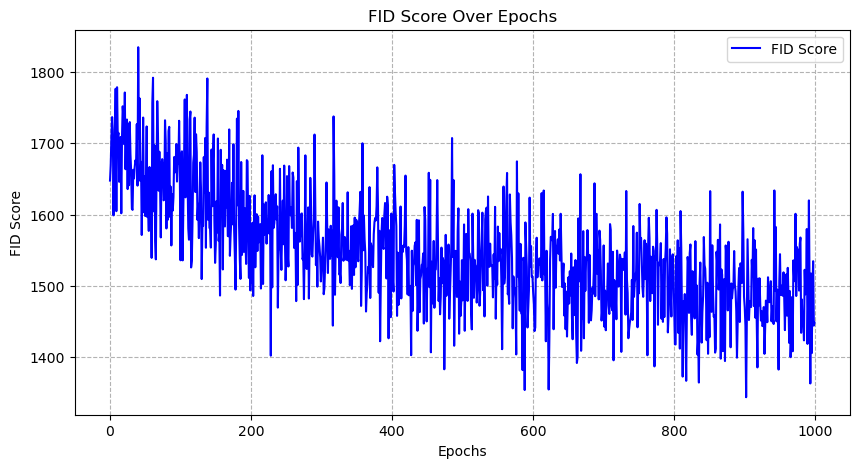

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(fid_scores, label='FID Score', color='blue')
plt.xlabel('Epochs')
plt.ylabel('FID Score')
plt.title('FID Score Over Epochs')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.7')
plt.show()

In [18]:
vae

VAE(
  (fc1): Linear(in_features=120001, out_features=400, bias=True)
  (bn1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=21, out_features=400, bias=True)
  (bn2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=400, out_features=120000, bias=True)
)

In [31]:
# # Train the model
# from tqdm import tqdm

# num_epochs = 50
# for epoch in tqdm(range(1, num_epochs + 1), desc="Training"):
#     train(epoch)

In [32]:
def generate_samples(num_samples, ground_truth_value):
    vae.eval()  # Set the VAE to evaluation mode
    with torch.no_grad():  # No need to track the gradients
        # Sample from a standard normal distribution
        z = torch.randn(num_samples, 20).to(device)
        ground_truth = torch.tensor([ground_truth_value]*num_samples).view(-1, 1).to(device)
        # Decode the samples
        samples = vae.decode(torch.cat((z, ground_truth), dim=-1))
    return samples

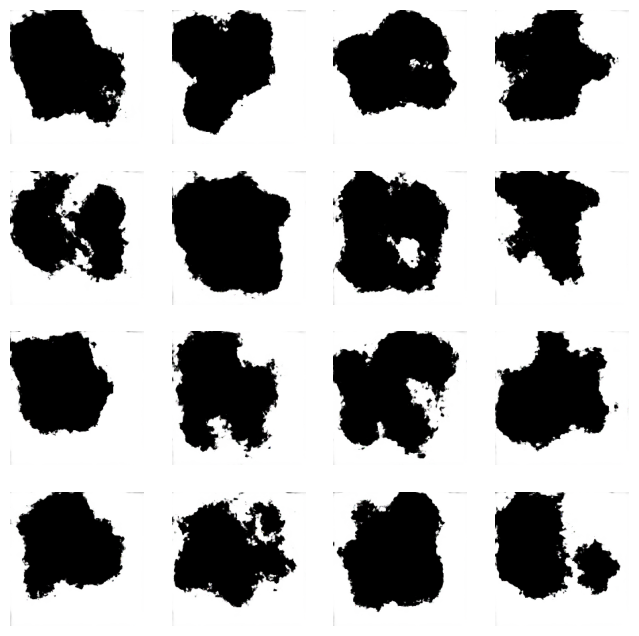

In [33]:
import matplotlib.pyplot as plt

# Generate 16 samples with a ground truth value of 0.5
samples = generate_samples(16, 1.5)

# Reshape the samples to image format and move them to CPU
samples = samples.view(-1, 3, 200, 200).cpu()

# Create a grid of images and convert them to numpy arrays
samples = samples.permute(0, 2, 3, 1).numpy()

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axs.flat):
    ax.imshow(samples[i])
    ax.axis('off')
plt.show()

In [34]:
!pip install torchsummary

In [35]:
from torchsummary import summary

In [36]:
from torchsummary import summary

# Custom hook to adapt the input for the VAE model
def new_forward(self, combined_input):
    # Extract image and ground truth from the combined input tensor
    x = combined_input[:, :-1].view(-1, 3, 200, 200)  # Reshape the image tensor
    ground_truth = combined_input[:, -1].view(-1, 1)  # Extract the ground truth tensor
    
    x = x.view(x.size(0), -1)  # Flatten the image tensor for the original forward function
    return VAE.forward(self, x, ground_truth)

# Temporarily replace the forward function of the VAE model with our custom hook
vae.forward = new_forward.__get__(vae)

# Adjust the input size to be a single tensor combining both image and ground truth
adjusted_input_size = (3 * 200 * 200 + 1,)

# Display the model summary with the adjusted input
summary(vae, adjusted_input_size)

# Restore the original forward function to the VAE model
vae.forward = VAE.forward.__get__(vae)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]      48,000,800
       BatchNorm1d-2                  [-1, 400]             800
            Linear-3                   [-1, 20]           8,020
            Linear-4                   [-1, 20]           8,020
            Linear-5                  [-1, 400]           8,800
       BatchNorm1d-6                  [-1, 400]             800
            Linear-7               [-1, 120000]      48,120,000
Total params: 96,147,240
Trainable params: 96,147,240
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 0.93
Params size (MB): 366.77
Estimated Total Size (MB): 368.16
----------------------------------------------------------------


In [22]:
torch.save(vae, 'vae_model.pth')

In [23]:
vae

VAE(
  (fc1): Linear(in_features=120001, out_features=400, bias=True)
  (bn1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=21, out_features=400, bias=True)
  (bn2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=400, out_features=120000, bias=True)
)